# Traffic Sign Recognizer

>* Author | Yousef Mahmoud Abdullah
>* SID   | 21020670

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import layers                                            # type: ignore    
from tensorflow.keras.models import Model, Sequential                          # type: ignore
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam                                   # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator            # type: ignore
from tensorflow.keras.applications import VGG19, ResNet50                      # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Dropout                    # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator            # type: ignore

import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Limit memory to 7.5 GB
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=7500)]
        )
    except RuntimeError as e:
        print(f"Error setting memory limit: {e}")

## Assigning Path for Dataset

In [ ]:
data_dir = 'data_folder_path'
train_path = 'train_folder_path'
test_path = 'test_folder_path'

# Data Avaliable at https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code

# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

## Finding Total Classes

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

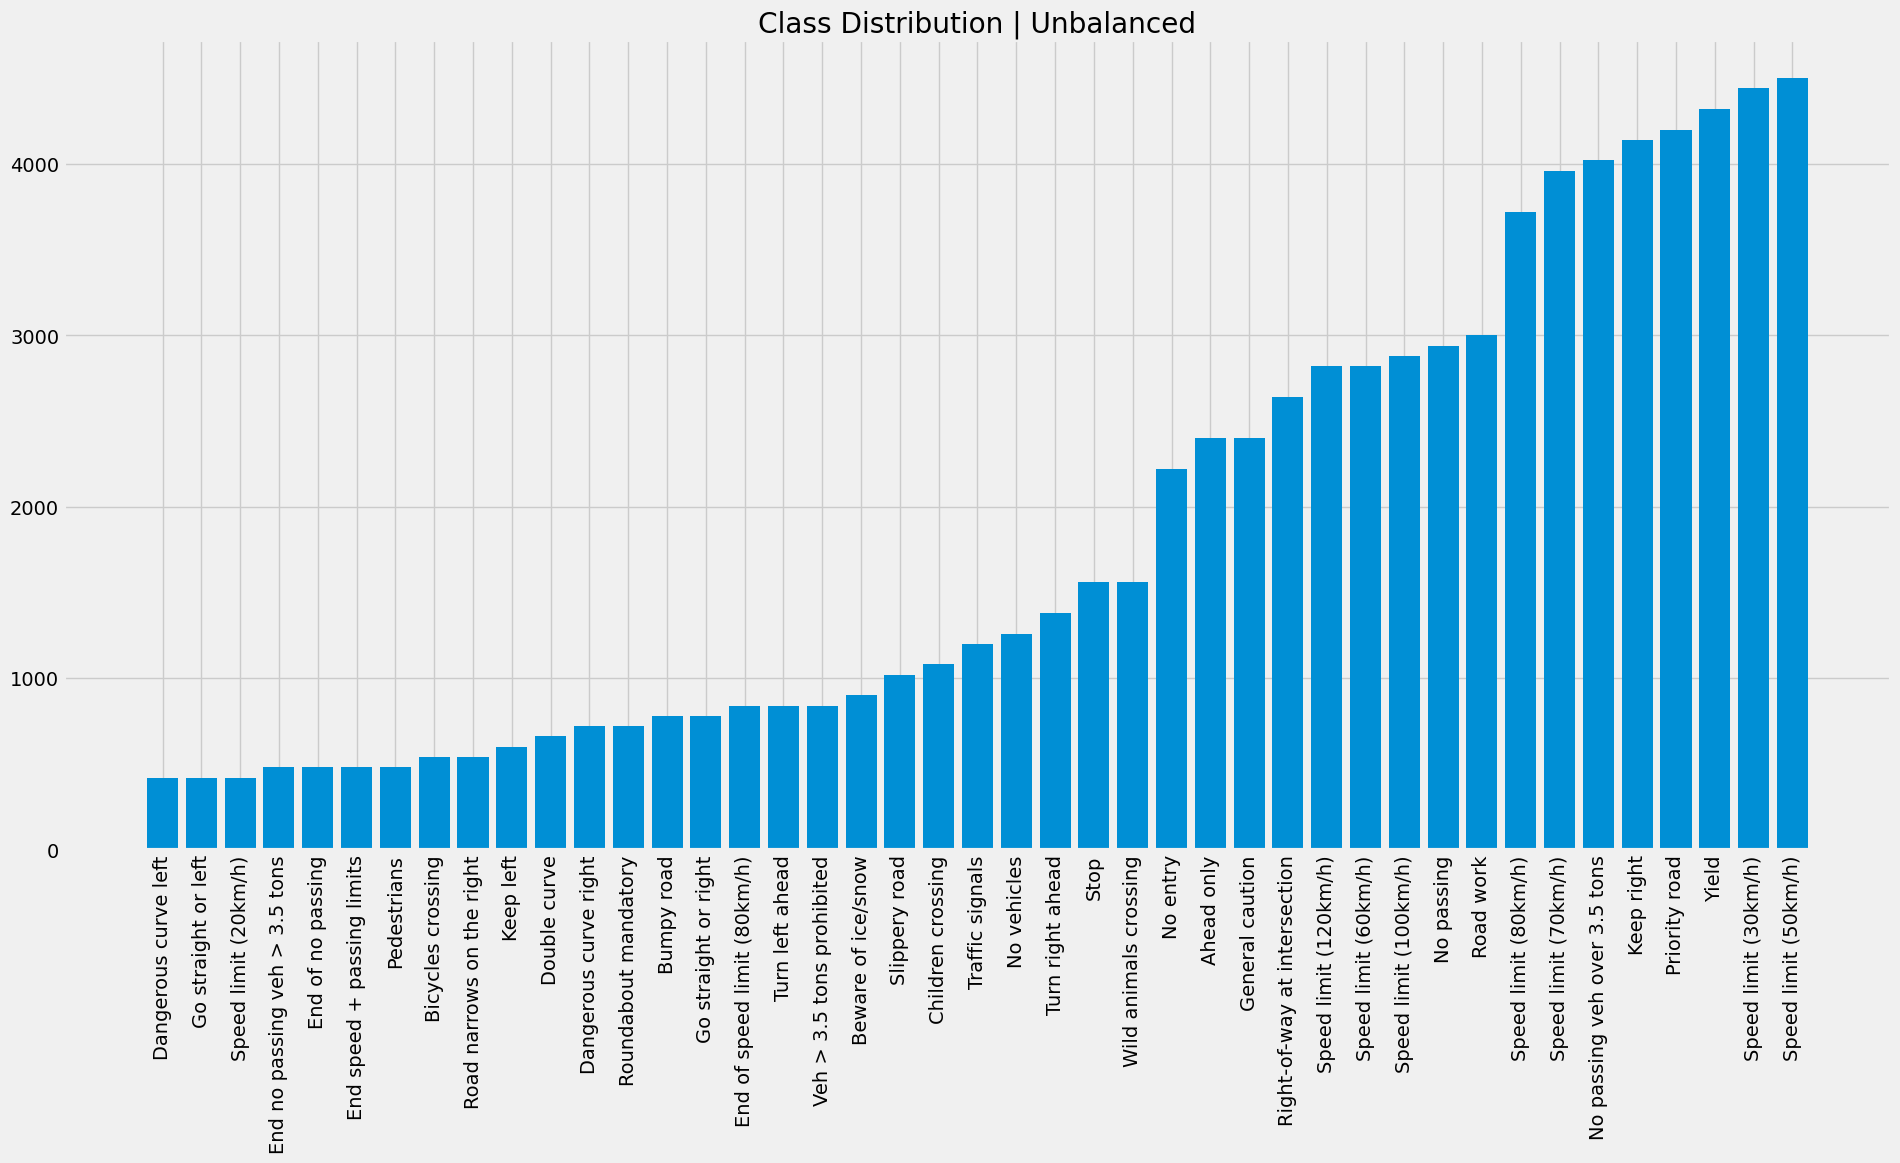

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.title("Class Distribution | Unbalanced")
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

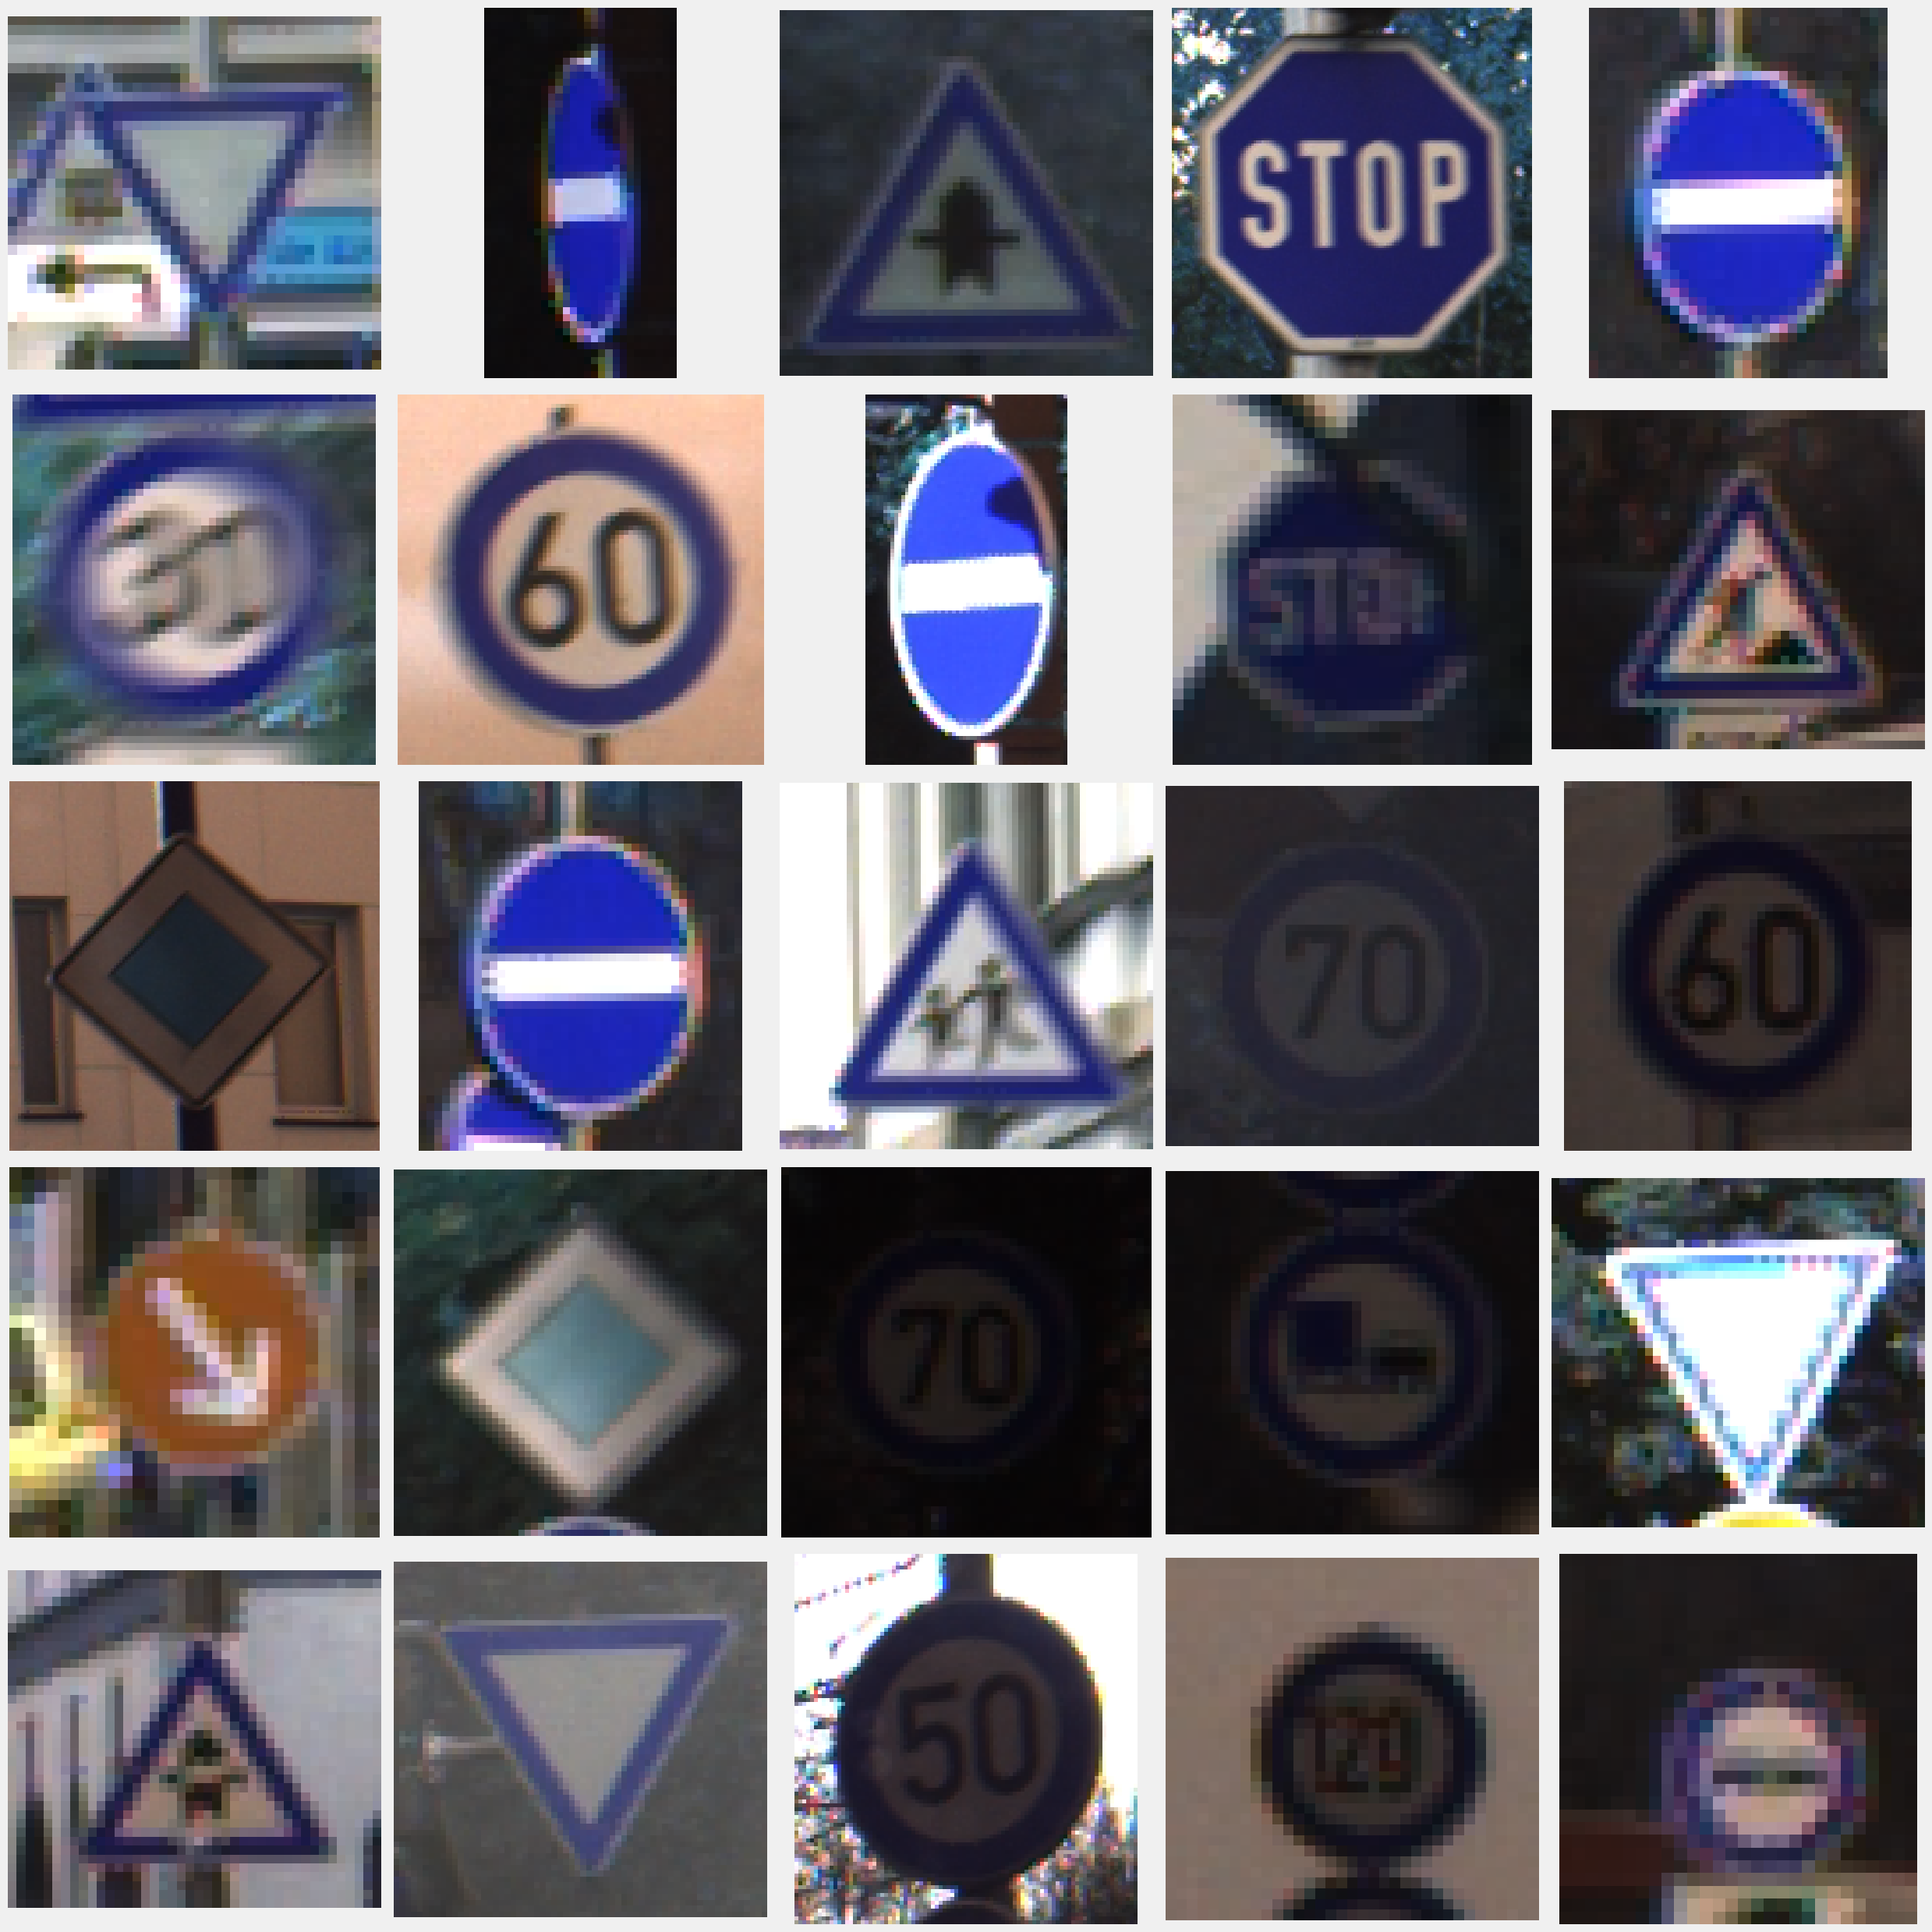

In [7]:
test = pd.read_csv(data_dir + 'Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25, 25))
selected_imgs = random.sample(list(imgs), 25)

for i, img_path in enumerate(selected_imgs, 1):
    plt.subplot(5, 5, i)
    random_img_path = data_dir + img_path
    try:
        rand_img = cv2.imread(random_img_path)
        plt.imshow(rand_img)
        plt.axis('off')  # Turn off grid and axis
        plt.xlabel(f"Width: {rand_img.shape[1]}", fontsize=15)
        plt.ylabel(f"Height: {rand_img.shape[0]}", fontsize=15)
    except Exception as e:
        print(f"Error loading {random_img_path}: {e}")
        plt.text(0.5, 0.5, 'Error', fontsize=15, ha='center', va='center')

plt.tight_layout()
plt.show()


## Collecting the Training Data

In [8]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

(78418, 32, 32, 3) (78418,)


## Balancing the data

In [9]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

# Target number of images per class
TARGET_SIZE = 500

# Unique classes
unique_classes = np.unique(image_labels)

# Create balanced dataset
balanced_data = []
balanced_labels = []

for cls in unique_classes:
    # Get images and labels for the current class
    cls_images = image_data[image_labels == cls]
    
    # Downsample if more than TARGET_SIZE
    if len(cls_images) > TARGET_SIZE:
        cls_images = resample(cls_images, n_samples=TARGET_SIZE, replace=False, random_state=42)
    
    # Augment if fewer than TARGET_SIZE
    elif len(cls_images) < TARGET_SIZE:
        augmented_images = []
        for img in cls_images:
            img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
            for _ in range(TARGET_SIZE - len(cls_images)):
                for batch in aug.flow(img, batch_size=1):
                    augmented_images.append(batch[0])
                    if len(augmented_images) + len(cls_images) >= TARGET_SIZE:
                        break
            if len(augmented_images) + len(cls_images) >= TARGET_SIZE:
                break
        cls_images = np.concatenate((cls_images, np.array(augmented_images[:TARGET_SIZE - len(cls_images)])), axis=0)

    # Add to balanced dataset
    balanced_data.extend(cls_images)
    balanced_labels.extend([cls] * len(cls_images))

# Convert to numpy arrays
balanced_data = np.array(balanced_data)
balanced_labels = np.array(balanced_labels)

print(f"Balanced data shape: {balanced_data.shape}")
print(f"Balanced labels shape: {balanced_labels.shape}")

Balanced data shape: (21500, 32, 32, 3)
Balanced labels shape: (21500,)


## Visualizing the dataset after balancing

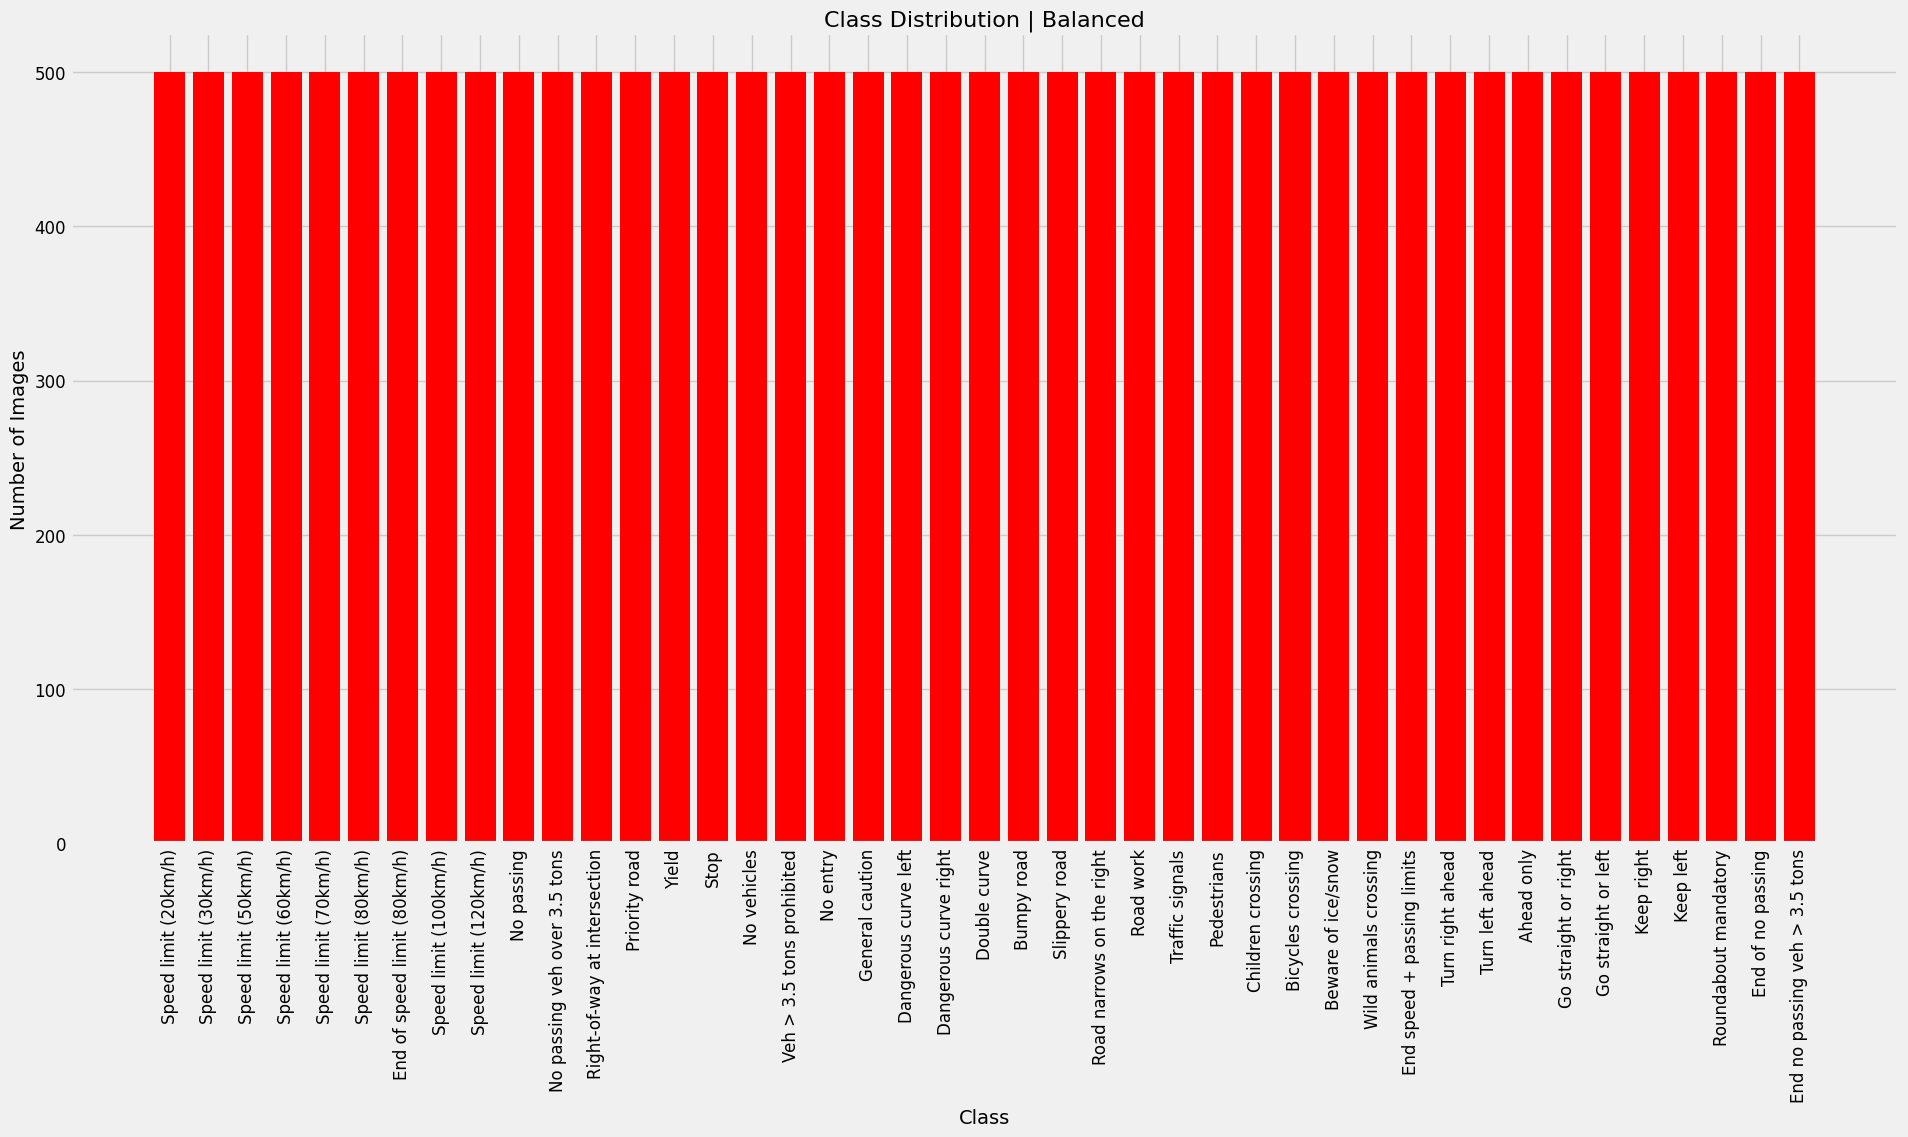

In [10]:
unique_classes, counts = np.unique(balanced_labels, return_counts=True)

# Sort the classes and counts for better visualization
sorted_indices = np.argsort(unique_classes)
sorted_classes = unique_classes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Map sorted class numbers to class names using the `classes` dictionary
class_names = [classes[int(c)] for c in sorted_classes]

# Plot the distribution with class names
plt.figure(figsize=(21, 10))
plt.bar(class_names, sorted_counts, color='red')
plt.xticks(class_names, rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Class Distribution | Balanced", fontsize=16)
plt.show()


In [11]:
print(image_data.shape)
print(balanced_data.shape)

(78418, 32, 32, 3)
(21500, 32, 32, 3)


## Splitting the data into train and validation set

In [12]:
X_train, X_val, y_train_temp, y_val_temp = train_test_split(balanced_data, balanced_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train / 255.0
X_val = X_val / 255.0

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train_temp.shape)
print("y_valid.shape", y_val_temp.shape)

X_train.shape (17200, 32, 32, 3)
X_valid.shape (4300, 32, 32, 3)
y_train.shape (17200,)
y_valid.shape (4300,)


## One hot encoding the labels

In [13]:
y_train = keras.utils.to_categorical(y_train_temp, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val_temp, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(17200, 43)
(4300, 43)


## Using Adam Optimizer 

In [14]:
opt = Adam(learning_rate=0.001)
epochs = 300
batch_size = 128

## Callbacks 
>* Early stopping
>* Readuce Learning Rate

In [15]:
# In this case, training will end after 10 epochs if there is no obvious improvement in validation loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#If, after 5 epochs, there is no improvement in validation loss, the learning rate will be cut in half (factor=0.5).
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

## Model 1 | Custom-CNN

In [16]:
model = Sequential([
    # Input layer defining the shape of the input images
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),

    # First convolutional block
    layers.Conv2D(32, (5, 5), activation='relu', padding='same'),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), # Normalizes activations to stabilize learning
    layers.MaxPool2D((2, 2)),    # Downsamples feature maps
    layers.Dropout(0.15),        # Regularization to prevent overfitting

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),

    # Fully connected classifier
    layers.Flatten(),                      # Converts 2D feature maps to 1D
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.BatchNormalization(),
    layers.Dropout(0.25),
     
    # Output layer for classification
    layers.Dense(NUM_CATEGORIES, activation='softmax')            
])


In [17]:
model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       7

### Training model 1

In [18]:
with tf.device('/GPU:0'):
    model.fit(
        X_train,
        y_train,
        batch_size= batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/300
135/135 [==============================] - 10s 31ms/step - loss: 0.8491 - accuracy: 0.7811 - val_loss: 9.6124 - val_accuracy: 0.0286 - lr: 0.0010
Epoch 2/300
135/135 [==============================] - 3s 23ms/step - loss: 0.0337 - accuracy: 0.9917 - val_loss: 18.4668 - val_accuracy: 0.0281 - lr: 0.0010
Epoch 3/300
135/135 [==============================] - 3s 23ms/step - loss: 0.0109 - accuracy: 0.9981 - val_loss: 19.8891 - val_accuracy: 0.0509 - lr: 0.0010
Epoch 4/300
135/135 [==============================] - 3s 23ms/step - loss: 0.0104 - accuracy: 0.9982 - val_loss: 1.5434 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 5/300
135/135 [==============================] - 3s 23ms/step - loss: 0.0127 - accuracy: 0.9969 - val_loss: 0.0606 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 6/300
135/135 [==============================] - 3s 21ms/step - loss: 0.0100 - accuracy: 0.9977 - val_loss: 0.0167 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 7/300
135/135 [==============================] - 

## Model 2 | Custom-CNN

In [19]:
model2 = keras.models.Sequential([
    # Set the input shape of the images 
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    
    # First Convolution Layer
    keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),

    # Second Convolution Layer
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),

    # Third Convolution Layer
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),

    # Fourth Convolution Layer
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),

    # Fully Connected Layers
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # Output Layer
    keras.layers.Dense(43, activation='softmax')
])


In [20]:
model2.compile(
            loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

### Training model 2

In [21]:
with tf.device('/GPU:0'):
    model2.fit(
        X_train,
        y_train,
        batch_size= batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/300
135/135 [==============================] - 2s 12ms/step - loss: 1.0132 - accuracy: 0.7426 - val_loss: 3.8787 - val_accuracy: 0.0651 - lr: 1.2500e-04
Epoch 2/300
135/135 [==============================] - 1s 10ms/step - loss: 0.0783 - accuracy: 0.9817 - val_loss: 3.6907 - val_accuracy: 0.0974 - lr: 1.2500e-04
Epoch 3/300
135/135 [==============================] - 1s 9ms/step - loss: 0.0289 - accuracy: 0.9953 - val_loss: 2.2098 - val_accuracy: 0.4040 - lr: 1.2500e-04
Epoch 4/300
135/135 [==============================] - 1s 10ms/step - loss: 0.0141 - accuracy: 0.9978 - val_loss: 0.2914 - val_accuracy: 0.9530 - lr: 1.2500e-04
Epoch 5/300
135/135 [==============================] - 1s 10ms/step - loss: 0.0092 - accuracy: 0.9990 - val_loss: 0.0475 - val_accuracy: 0.9909 - lr: 1.2500e-04
Epoch 6/300
135/135 [==============================] - 1s 10ms/step - loss: 0.0063 - accuracy: 0.9996 - val_loss: 0.0285 - val_accuracy: 0.9940 - lr: 1.2500e-04
Epoch 7/300
135/135 [==============

## Model 3 | Pre-trained VGG19 model

In [22]:
# Load VGG19 without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model.layers:
    layer.trainable = True

In [23]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)                   # Dropout for regularization
output = Dense(43, activation='softmax')(x)  # Output layer for classification

# Create the VGG19 model
VGG19_model = Model(inputs=base_model.input, outputs=output)
VGG19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

 dense_5 (Dense)             (None, 43)                11051     
                                                                 
Total params: 20,166,763
Trainable params: 20,166,763
Non-trainable params: 0
_________________________________________________________________


In [24]:
VGG19_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training Model 3

In [25]:
with tf.device('/GPU:0'):
    VGG19_model.fit(
        X_train,
        y_train,
        batch_size= batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/300
135/135 [==============================] - 9s 53ms/step - loss: 2.1485 - accuracy: 0.3887 - val_loss: 0.7350 - val_accuracy: 0.7714 - lr: 1.0000e-05
Epoch 2/300
135/135 [==============================] - 6s 45ms/step - loss: 0.6716 - accuracy: 0.7872 - val_loss: 0.2602 - val_accuracy: 0.9249 - lr: 1.0000e-05
Epoch 3/300
135/135 [==============================] - 6s 46ms/step - loss: 0.3643 - accuracy: 0.8862 - val_loss: 0.1923 - val_accuracy: 0.9363 - lr: 1.0000e-05
Epoch 4/300
135/135 [==============================] - 6s 48ms/step - loss: 0.2296 - accuracy: 0.9302 - val_loss: 0.1326 - val_accuracy: 0.9567 - lr: 1.0000e-05
Epoch 5/300
135/135 [==============================] - 7s 52ms/step - loss: 0.1810 - accuracy: 0.9444 - val_loss: 0.1046 - val_accuracy: 0.9665 - lr: 1.0000e-05
Epoch 6/300
135/135 [==============================] - 6s 42ms/step - loss: 0.1360 - accuracy: 0.9588 - val_loss: 0.0957 - val_accuracy: 0.9705 - lr: 1.0000e-05
Epoch 7/300
135/135 [=============

## Model 4 | Pre-trained ResNet50

In [26]:
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [27]:
# Load ResNet50 with pretrained ImageNet weights, excluding top classification layer
base_model_2 = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

for layer in base_model_2.layers:
    layer.trainable = True

In [28]:
x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_tensor = Dense(43, activation='softmax')(x)

# Final model
resnet_model = Model(inputs=base_model_2.input, outputs=output_tensor)  
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [29]:
resnet_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training Model 4

In [30]:
with tf.device('/GPU:0'):
    resnet_model.fit(
        X_train,
        y_train,
        batch_size= batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/300
135/135 [==============================] - 139s 723ms/step - loss: 4.2003 - accuracy: 0.0566 - val_loss: 14.8071 - val_accuracy: 0.0240 - lr: 1.0000e-05
Epoch 2/300
135/135 [==============================] - 87s 645ms/step - loss: 3.4342 - accuracy: 0.1380 - val_loss: 16.6765 - val_accuracy: 0.0244 - lr: 1.0000e-05
Epoch 3/300
135/135 [==============================] - 97s 715ms/step - loss: 3.0751 - accuracy: 0.2177 - val_loss: 18.1194 - val_accuracy: 0.0244 - lr: 1.0000e-05
Epoch 4/300
135/135 [==============================] - 91s 674ms/step - loss: 2.7255 - accuracy: 0.3067 - val_loss: 16.3901 - val_accuracy: 0.0277 - lr: 1.0000e-05
Epoch 5/300
135/135 [==============================] - 94s 697ms/step - loss: 2.4333 - accuracy: 0.3749 - val_loss: 8.3314 - val_accuracy: 0.0423 - lr: 1.0000e-05
Epoch 6/300
135/135 [==============================] - 87s 644ms/step - loss: 2.1576 - accuracy: 0.4478 - val_loss: 5.0684 - val_accuracy: 0.1177 - lr: 1.0000e-05
Epoch 7/300
135/1

## Evaluating the models

In [31]:
models = [model, model2, VGG19_model, resnet_model]
model_labels = ['Custom_CNN 1', 'Custom_CNN 2', 'VGG19', 'ResNet50']

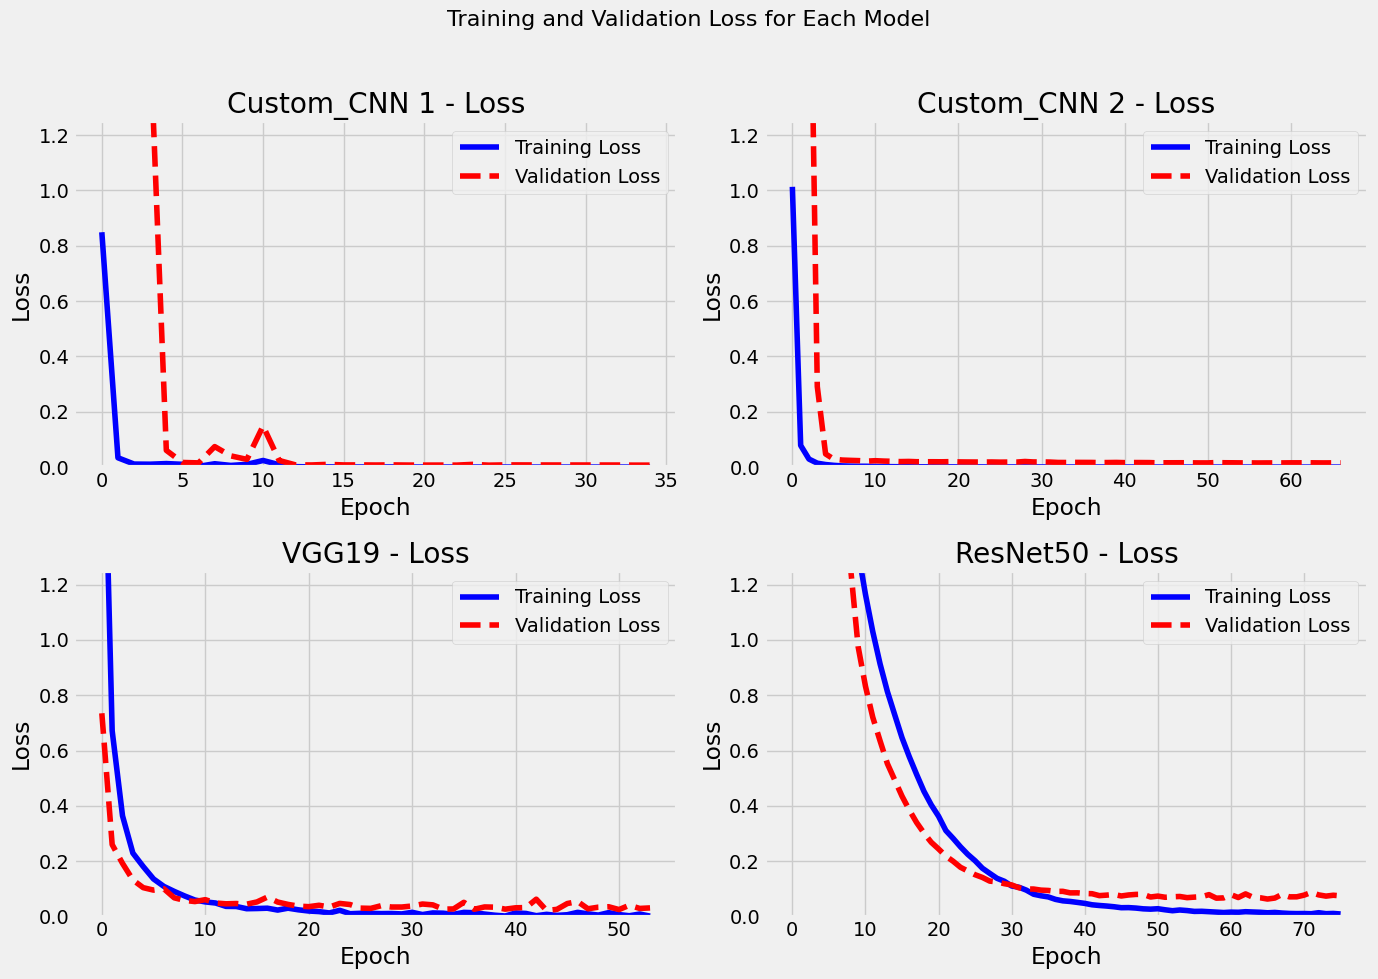

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, model in enumerate(models):
    df = pd.DataFrame(model.history.history)
    axs[i].plot(df['loss'], label='Training Loss', color='blue')
    axs[i].plot(df['val_loss'], label='Validation Loss', color='red', linestyle='--')
    axs[i].set_title(f'{model_labels[i]} - Loss')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_ylim(0, 1.25)

plt.suptitle('Training and Validation Loss for Each Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


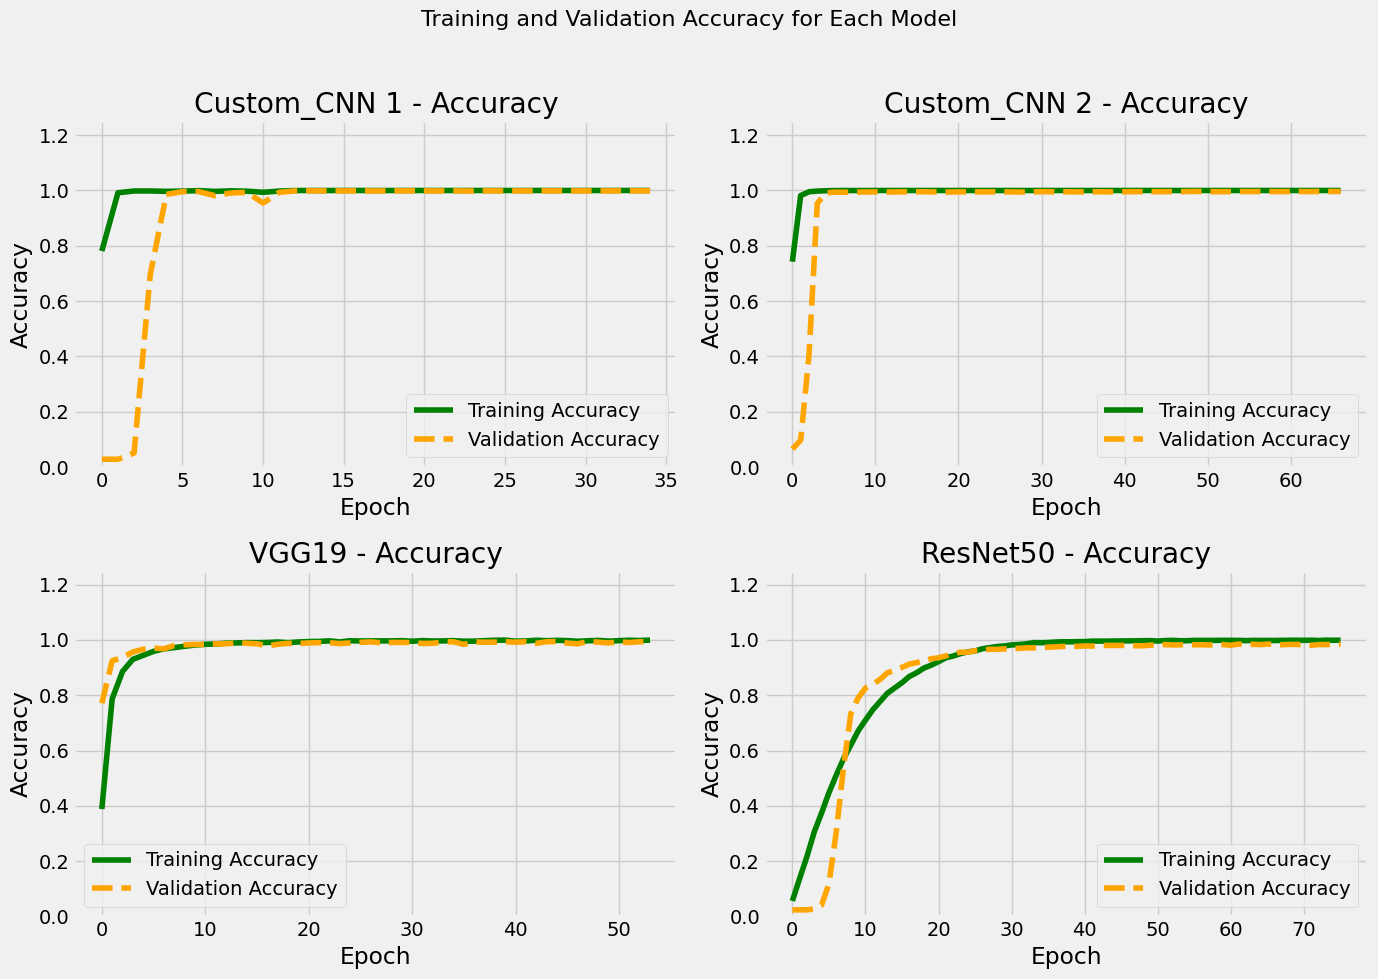

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, model in enumerate(models):
    df = pd.DataFrame(model.history.history)
    axs[i].plot(df['accuracy'], label='Training Accuracy', color='green')
    axs[i].plot(df['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
    axs[i].set_title(f'{model_labels[i]} - Accuracy')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_ylim(0, 1.25)

plt.suptitle('Training and Validation Accuracy for Each Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Loading the test data and testing the models

In [34]:
# Load test data
test = pd.read_csv(data_dir + 'Test.csv')
y_test = test["ClassId"].values
imgs = test["Path"].values

In [35]:
# Load and preprocess images
data = []

In [36]:
for index, img in enumerate(imgs):
    try:
        image = cv2.imread(data_dir + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
        print(f"Deleted image {img} and its label: {labels[index]}")
        labels = np.delete(labels, index)

# Convert to Numpy array
X_test = np.array(data)

# Normalization
X_test = X_test/255.0

In [37]:
accuracies = []
confusion_matrices = []
classification_reports = []
classification_reports_dicts = []

for i, model in enumerate(models):
    # Predictions
    print(f"Testing {model_labels[i]} accuracy")
    preds = np.argmax(model.predict(X_test), axis=-1)
    
    # Metrics
    acc = accuracy_score(y_test, preds)
    cf = confusion_matrix(y_test, preds)
    cr_text = classification_report(y_test, preds)
    cr_dict = classification_report(y_test, preds, output_dict=True)


    accuracies.append(acc)
    confusion_matrices.append(cf)
    classification_reports.append(cr_text)
    classification_reports_dicts.append(cr_dict)

    print(f"{model_labels[i]} Test Accuracy: {acc * 100:.2f}%")

Testing Custom_CNN 1 accuracy
395/395 [==============================] - 1s 2ms/step
Custom_CNN 1 Test Accuracy: 97.44%
Testing Custom_CNN 2 accuracy
395/395 [==============================] - 1s 1ms/step
Custom_CNN 2 Test Accuracy: 95.56%
Testing VGG19 accuracy
395/395 [==============================] - 4s 8ms/step
VGG19 Test Accuracy: 92.22%
Testing ResNet50 accuracy
395/395 [==============================] - 5s 9ms/step
ResNet50 Test Accuracy: 79.99%


### Comparing the models accuracies

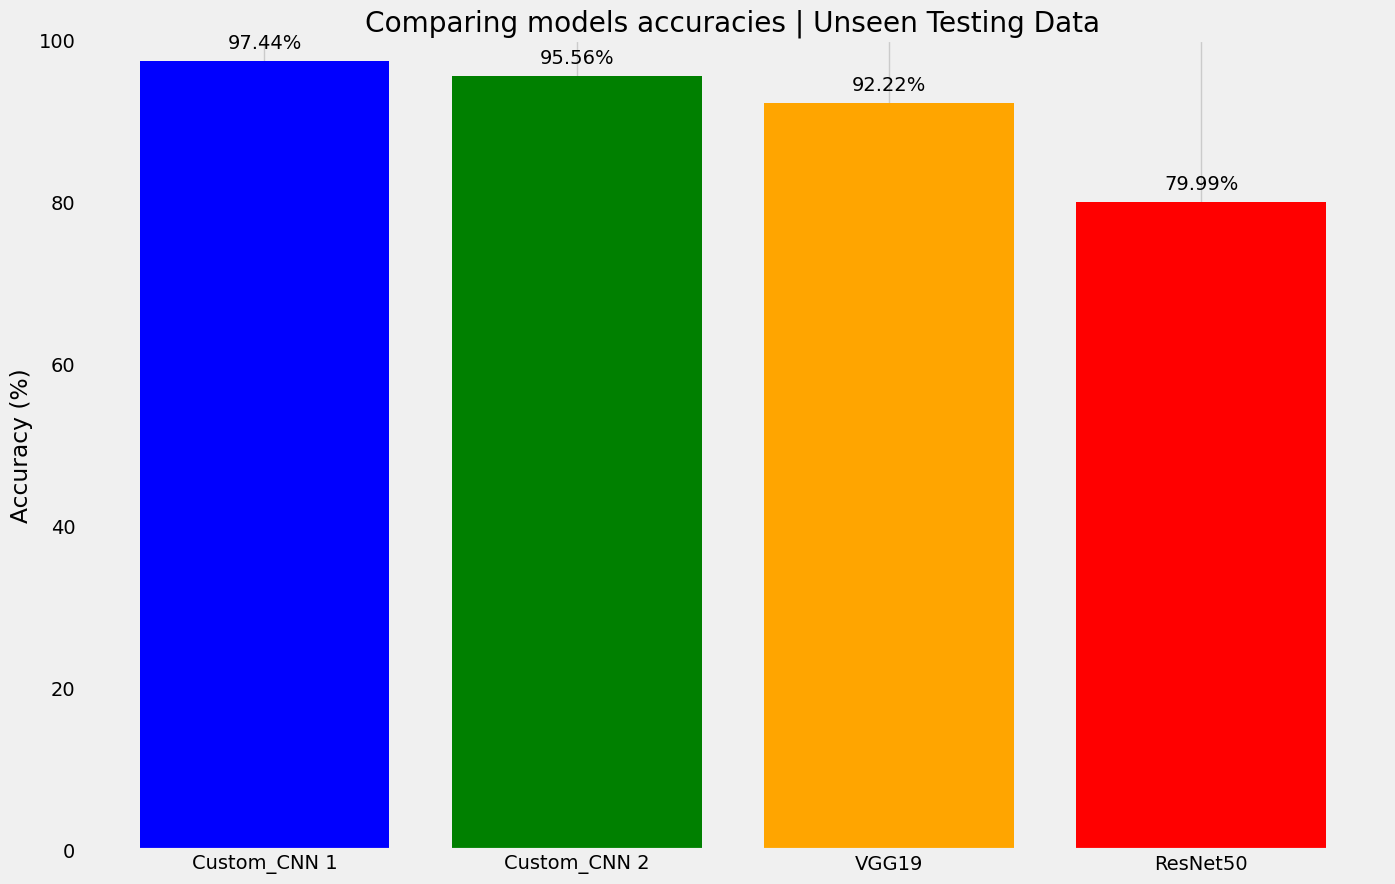

In [38]:
# Plot accuracies
plt.figure(figsize=(15, 10))
bars = plt.bar(model_labels, [a * 100 for a in accuracies], color=['blue', 'green', 'orange', 'red'])

# Add text labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Comparing models accuracies | Unseen Testing Data')
plt.grid(axis='y')
plt.show()

### Visualizing the confusion matrix of each model

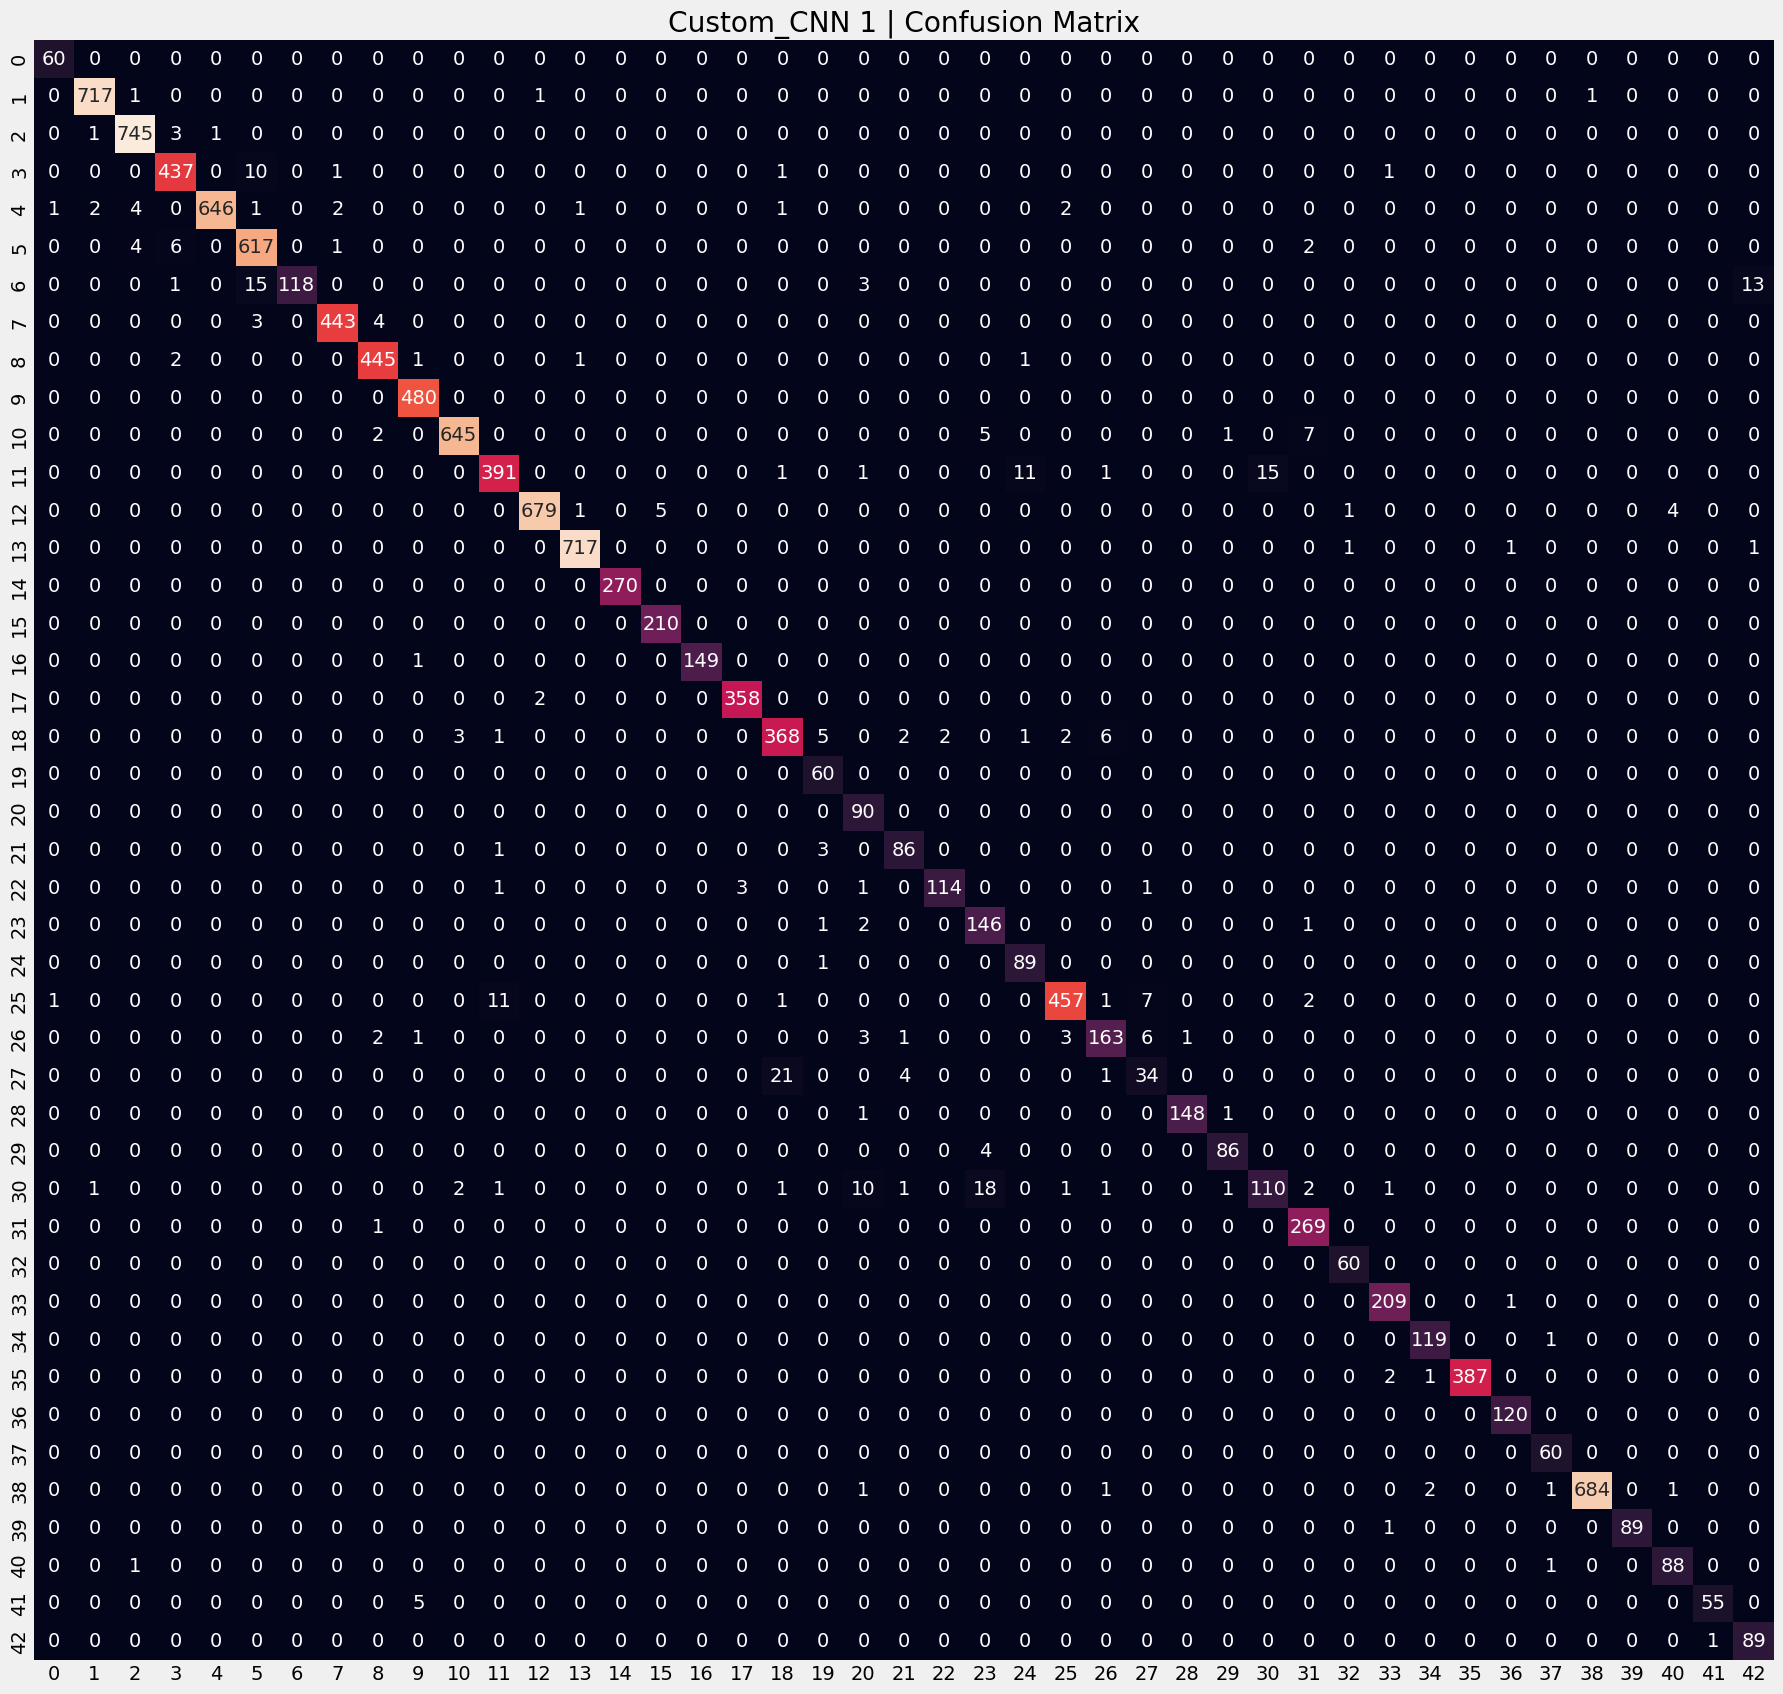

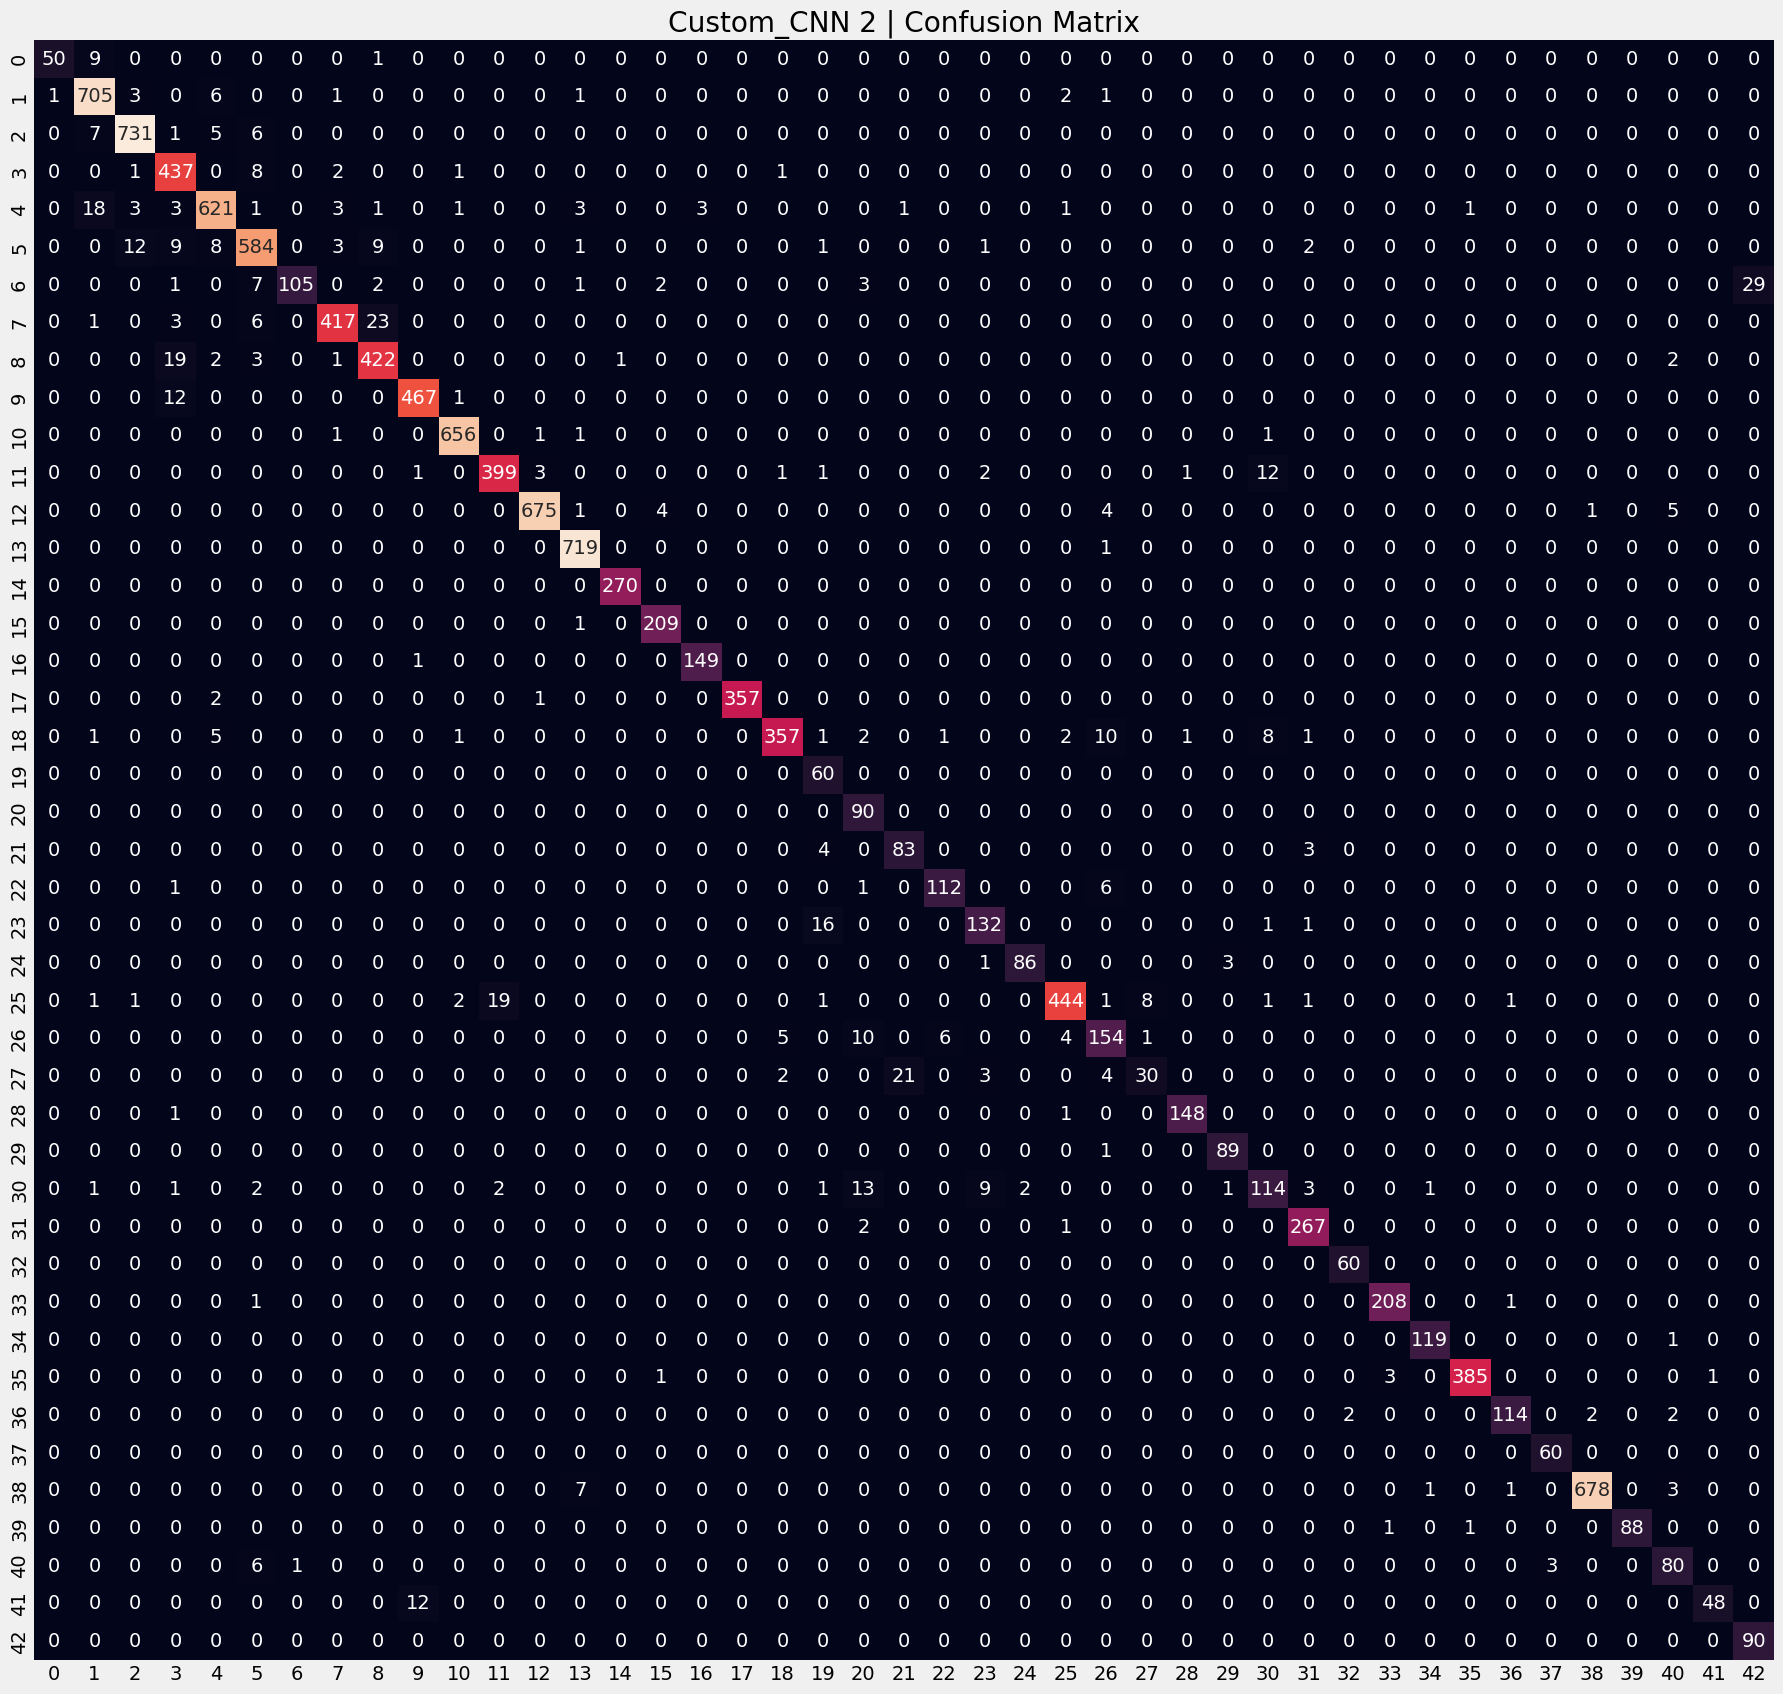

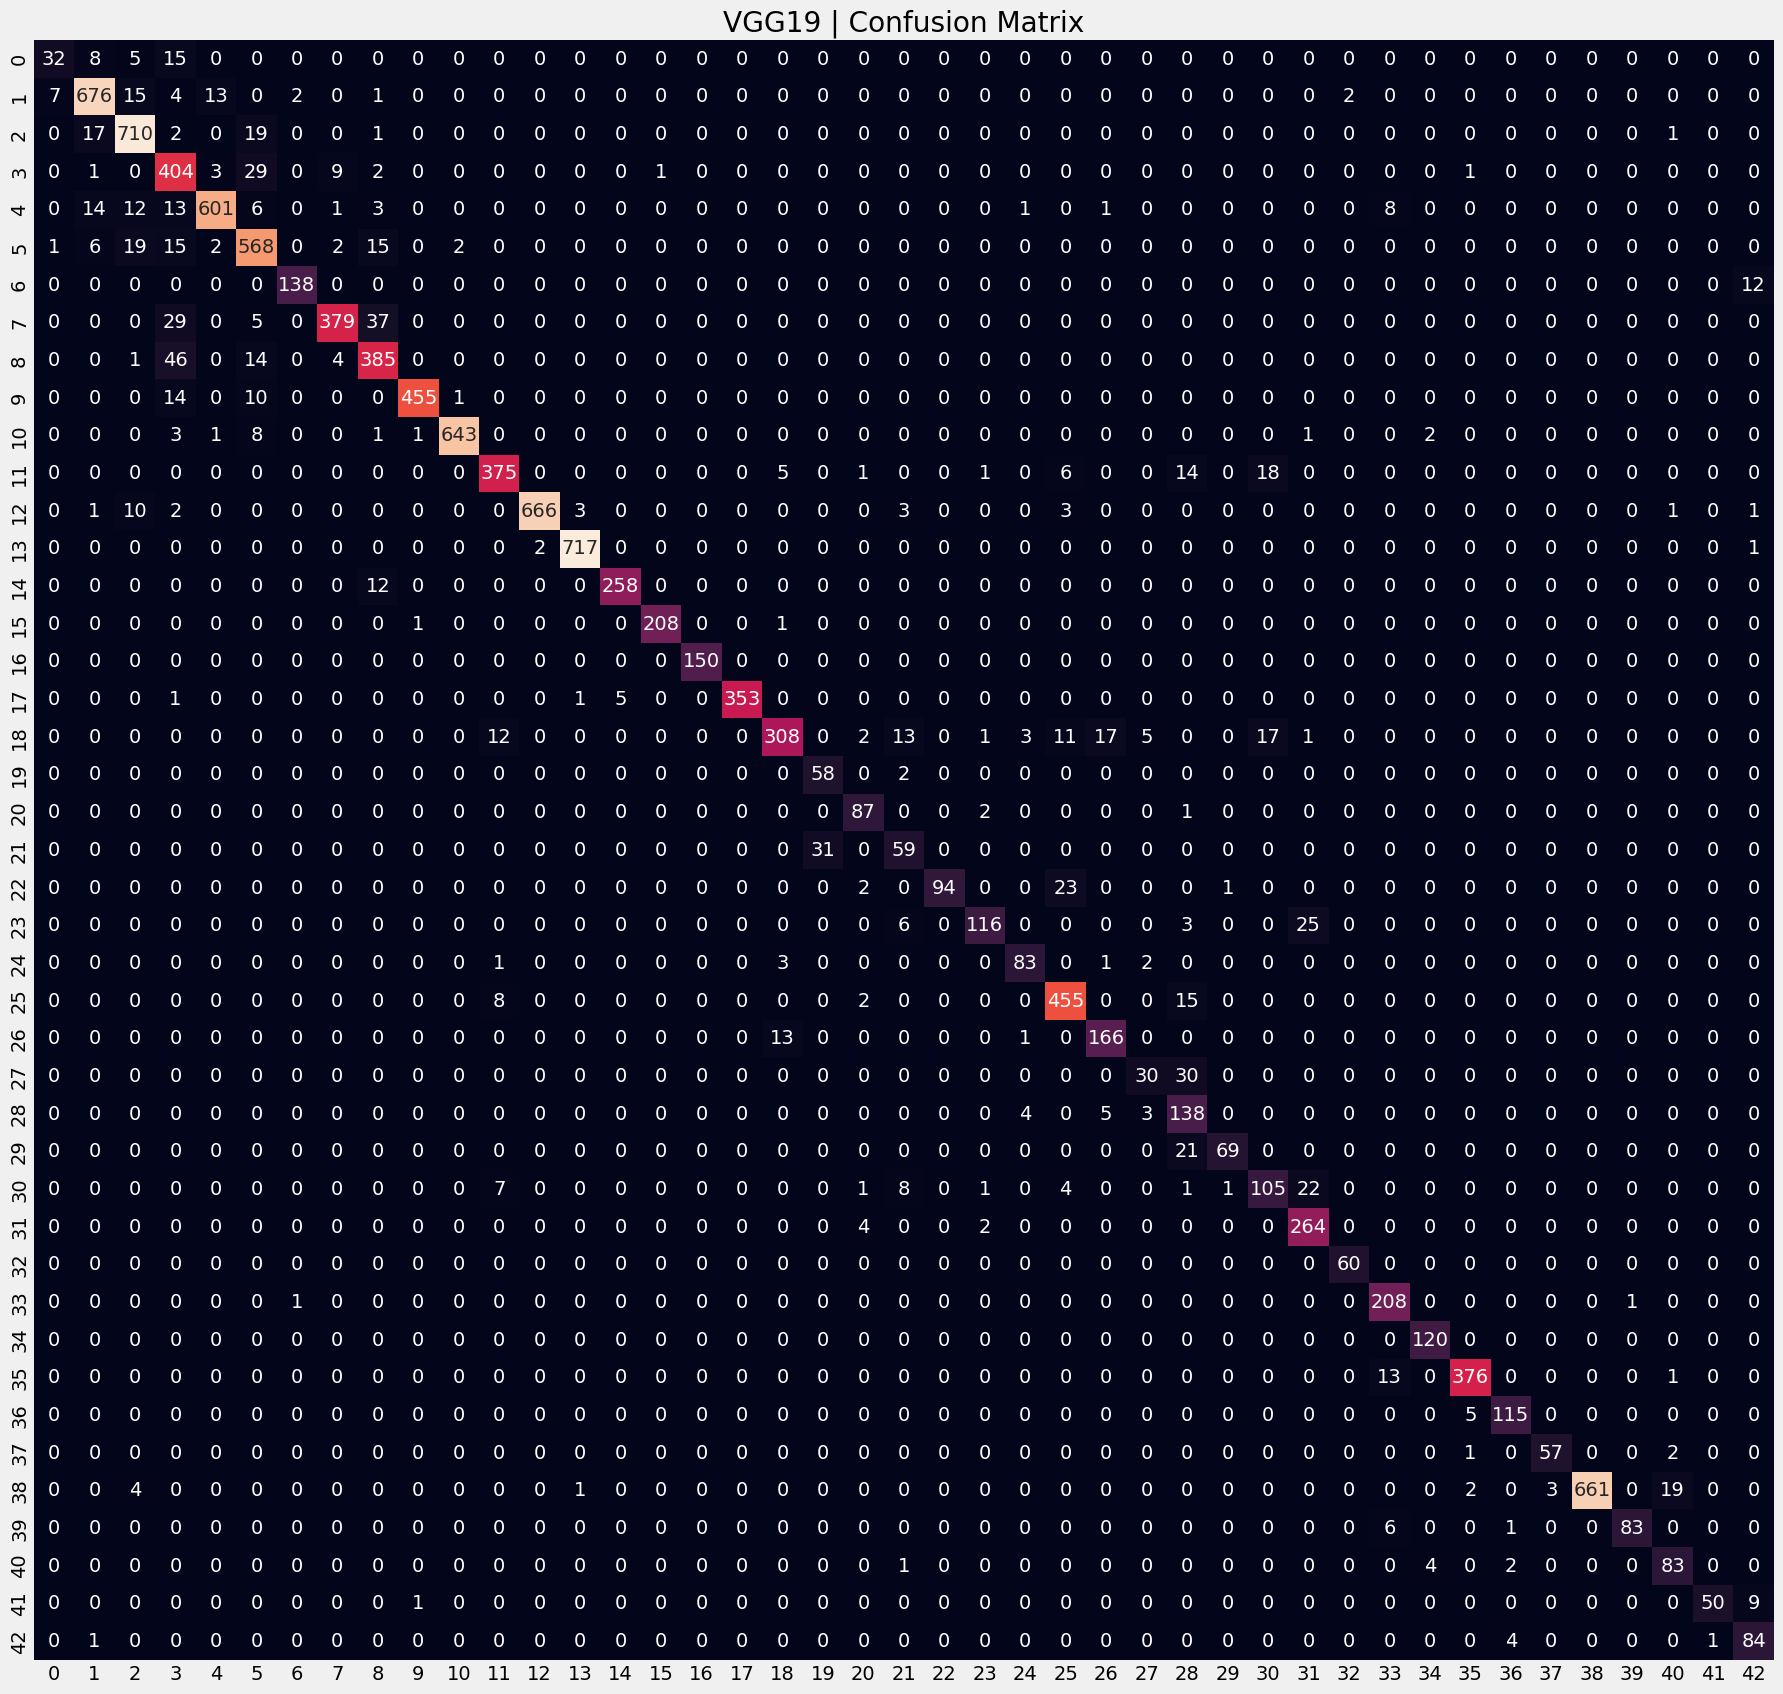

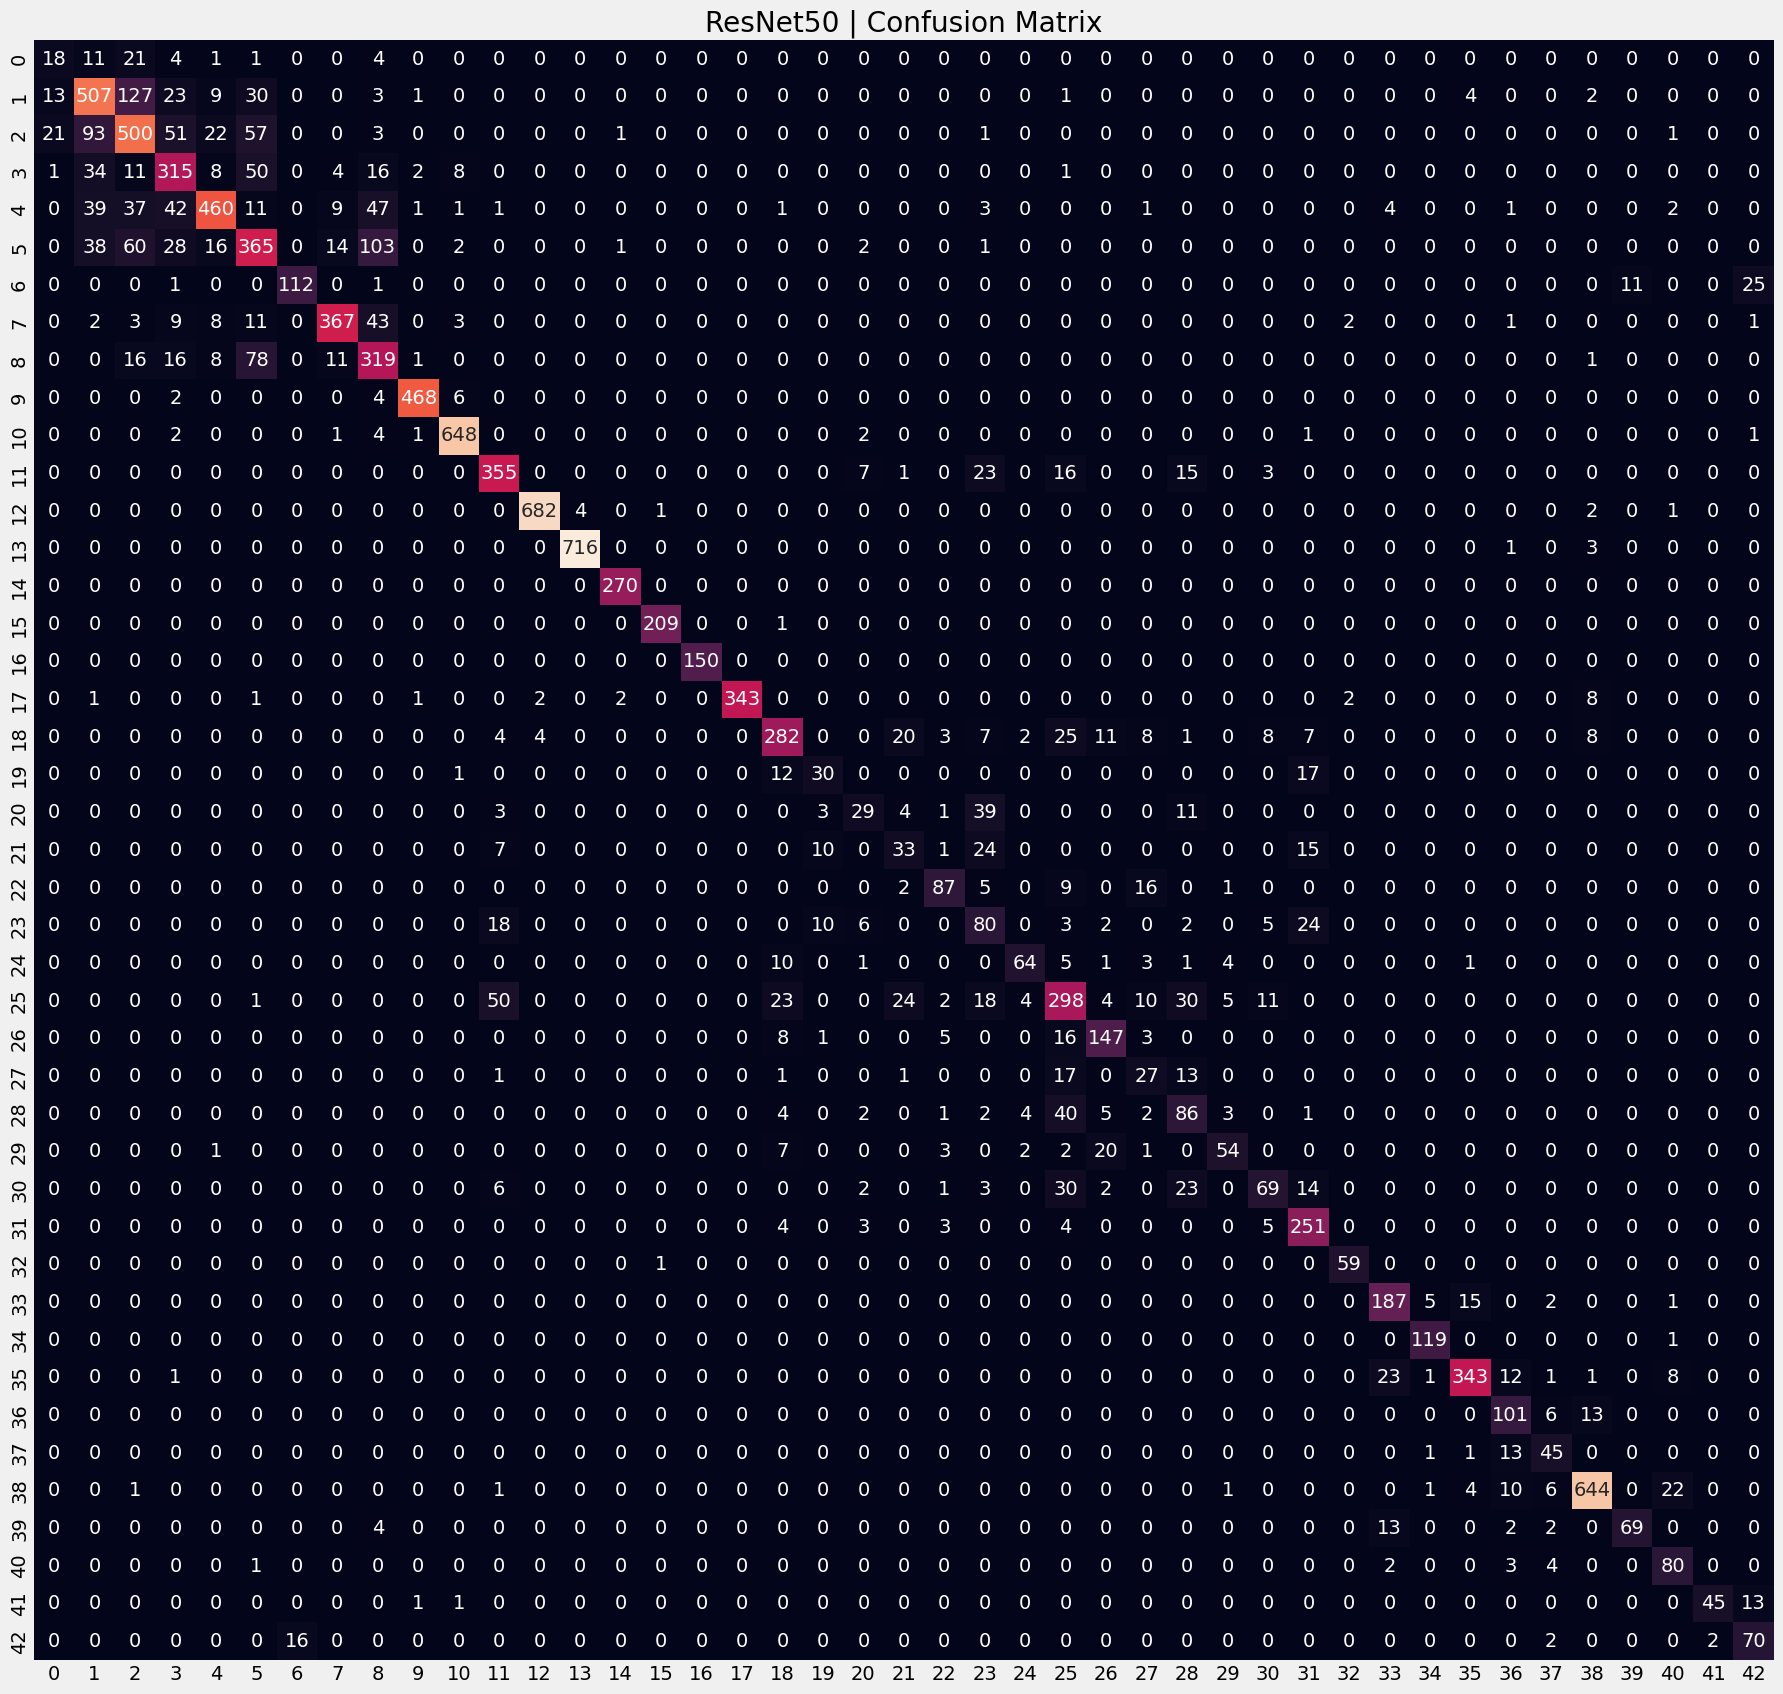

In [56]:
for i, cf in enumerate(confusion_matrices):
    plt.figure(figsize=(20, 20))
    df_cm = pd.DataFrame(cf, index=classes,  columns=classes)
    plt.title(f"{model_labels[i]} | Confusion Matrix")
    sns.heatmap(df_cm, annot=True, fmt='d', cbar=False);

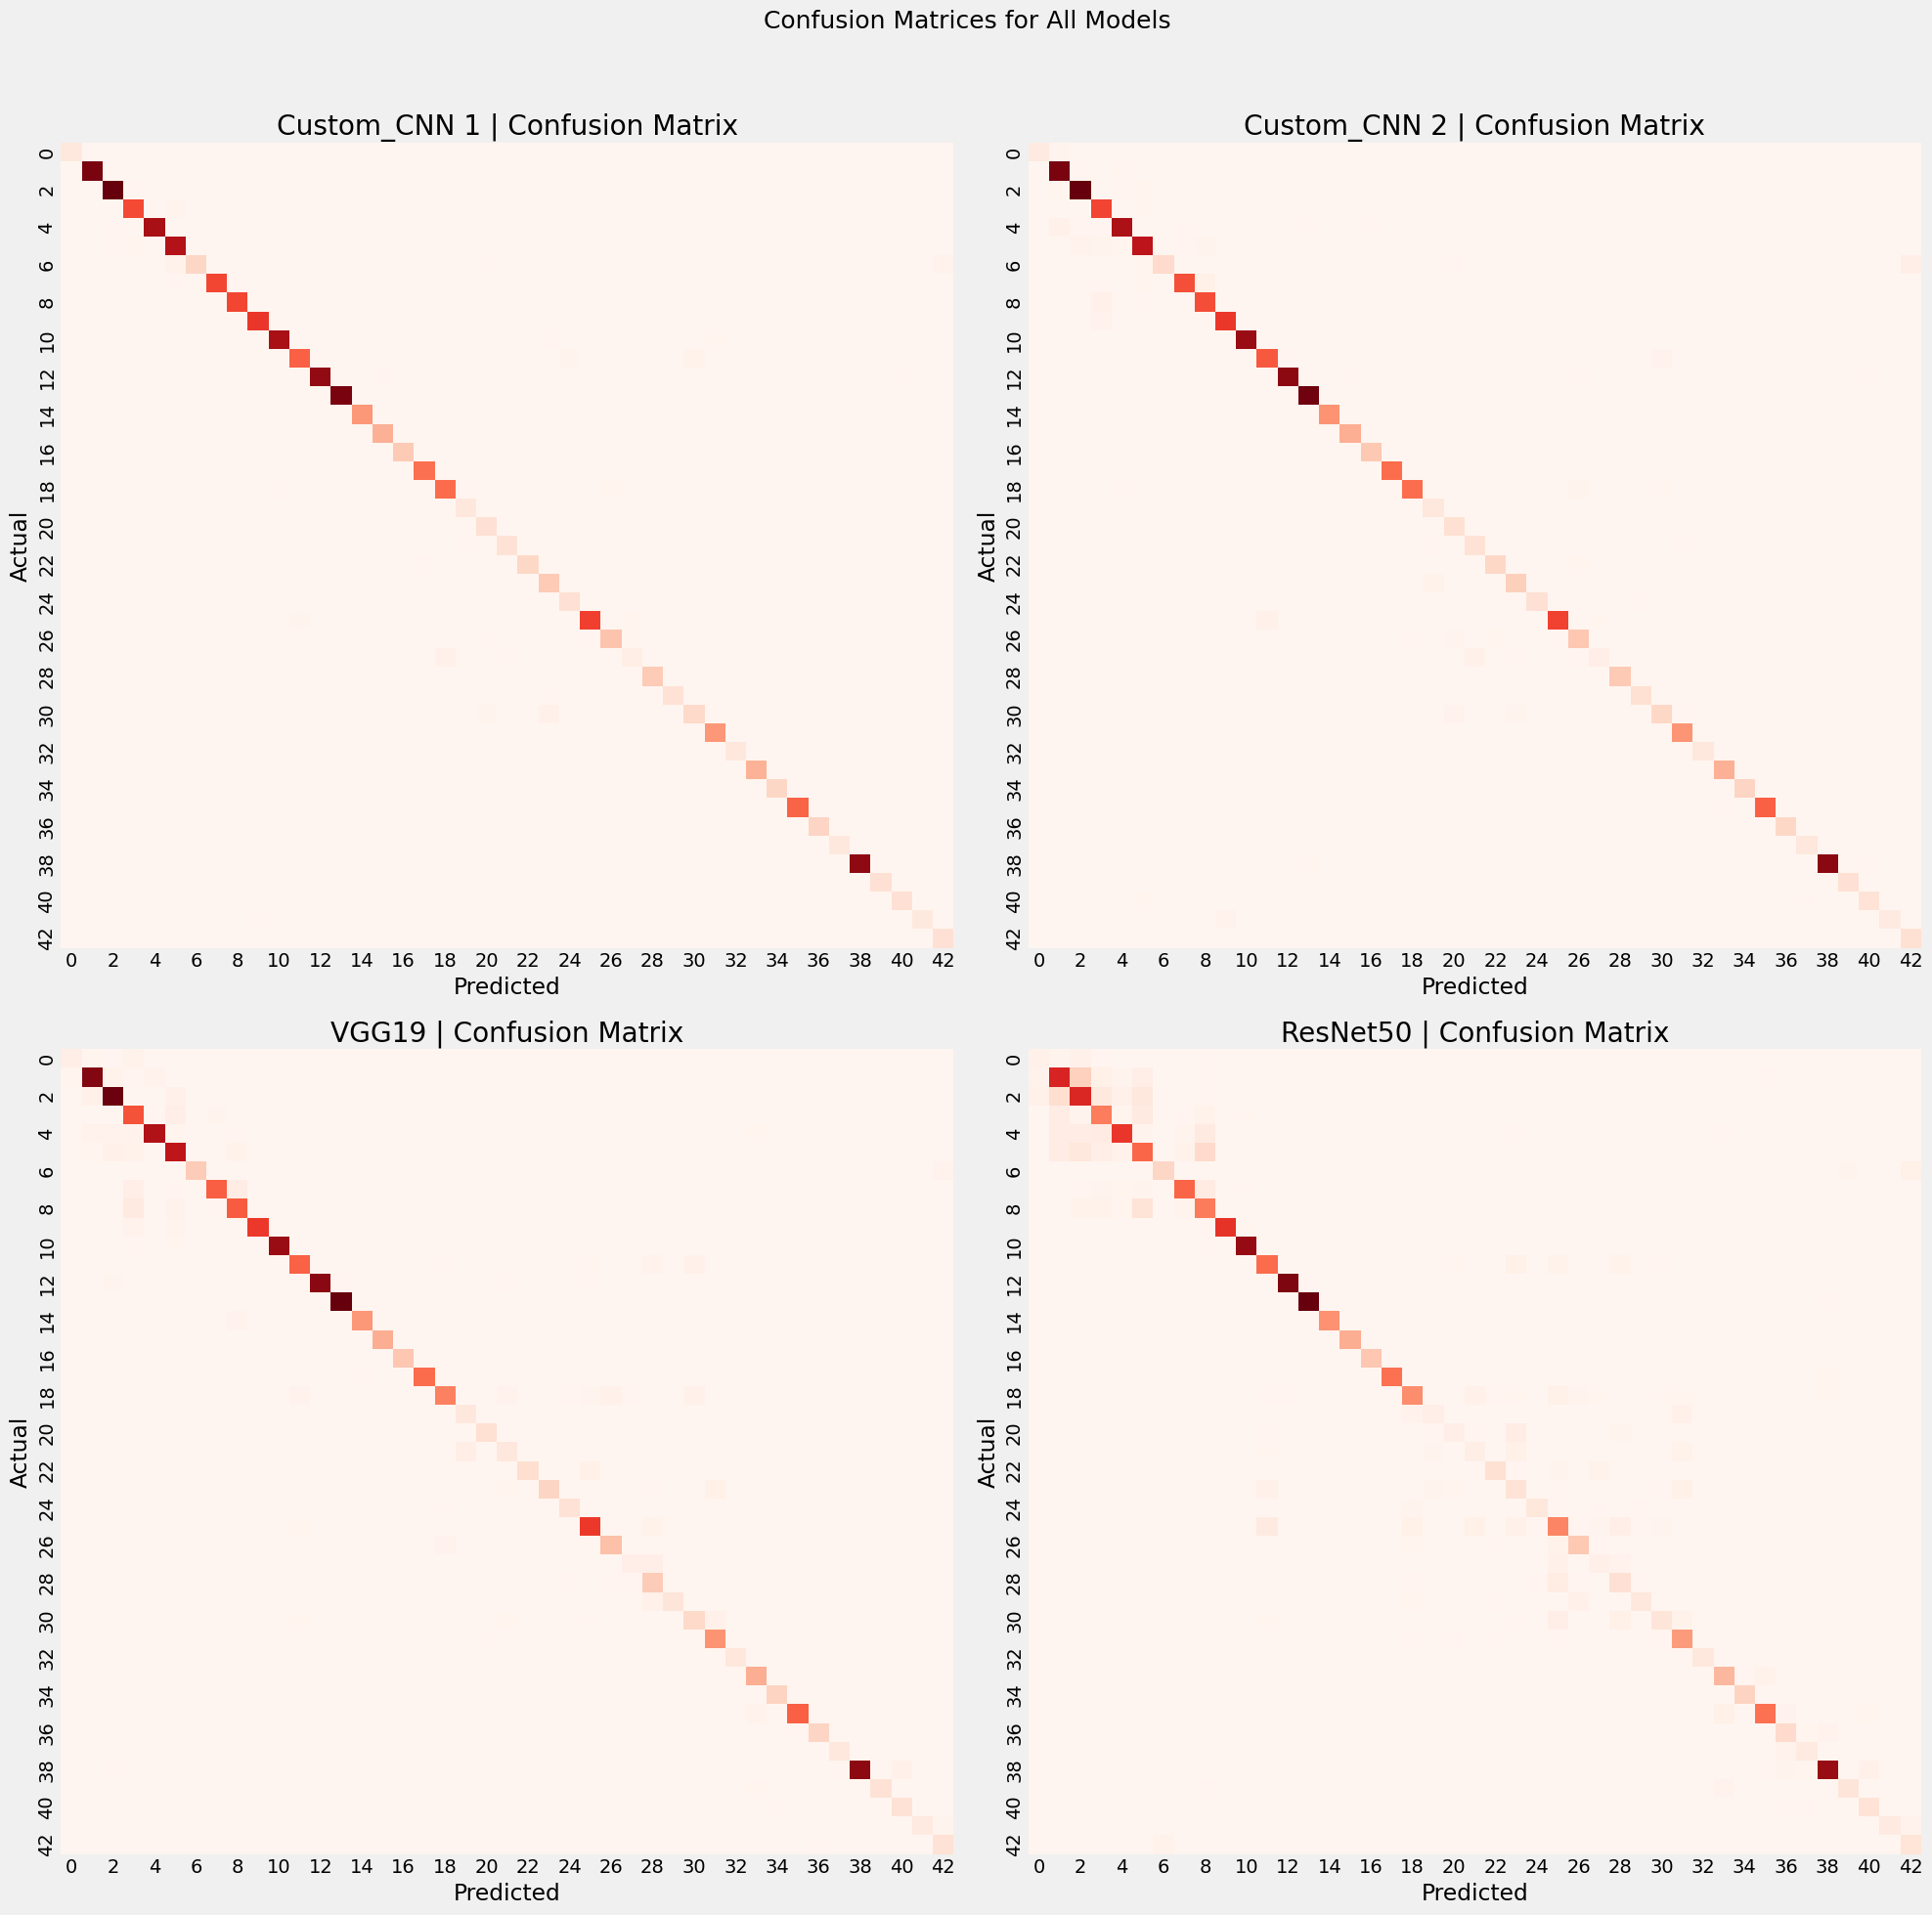

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))  # 2x2 grid
axs = axs.flatten()

for i, cf in enumerate(confusion_matrices):
    df_cm = pd.DataFrame(cf, index=classes, columns=classes)
    sns.heatmap(df_cm, annot=False, cbar=False, cmap="Reds", ax=axs[i])
    axs[i].set_title(f"{model_labels[i]} | Confusion Matrix")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")

plt.suptitle("Confusion Matrices for All Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Classification Reports

In [41]:
for i, cr in enumerate(classification_reports):
    print(f"{model_labels[i]} | Classification Report\n{cr}\n\n")

Custom_CNN 1 | Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.99      1.00      1.00       720
           2       0.99      0.99      0.99       750
           3       0.97      0.97      0.97       450
           4       1.00      0.98      0.99       660
           5       0.96      0.98      0.97       630
           6       1.00      0.79      0.88       150
           7       0.99      0.98      0.99       450
           8       0.98      0.99      0.98       450
           9       0.98      1.00      0.99       480
          10       0.99      0.98      0.98       660
          11       0.96      0.93      0.95       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      0.99      1.00 

### Comparing Classification Reports

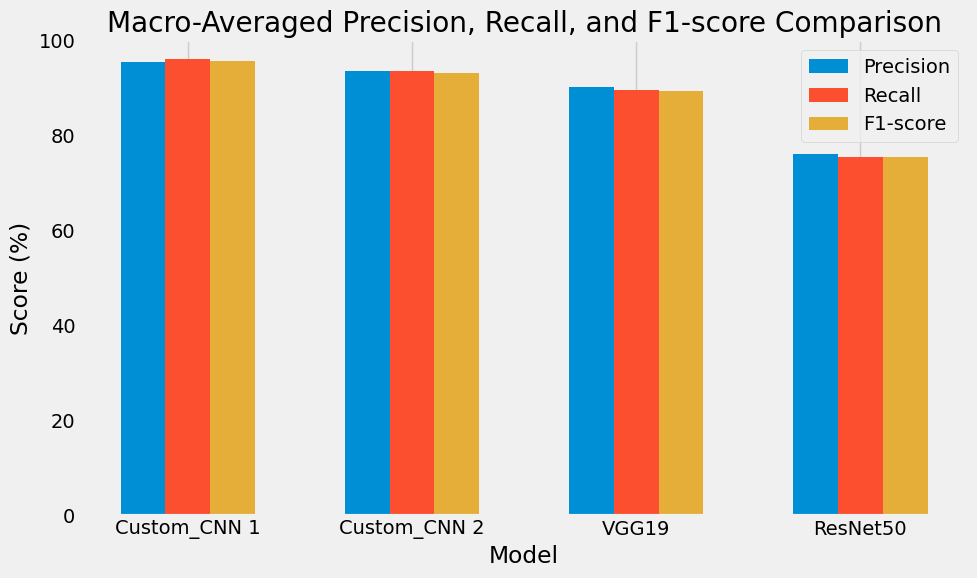

In [42]:
metrics = {'precision': [], 'recall': [], 'f1-score': []}

for cr in classification_reports_dicts:
    metrics['precision'].append(cr['macro avg']['precision'])
    metrics['recall'].append(cr['macro avg']['recall'])
    metrics['f1-score'].append(cr['macro avg']['f1-score'])

x = np.arange(len(model_labels))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, [v * 100 for v in metrics['precision']], width, label='Precision')
plt.bar(x,         [v * 100 for v in metrics['recall']],    width, label='Recall')
plt.bar(x + width, [v * 100 for v in metrics['f1-score']],  width, label='F1-score')

plt.xlabel('Model')
plt.ylabel('Score (%)')
plt.title('Macro-Averaged Precision, Recall, and F1-score Comparison')
plt.xticks(x, model_labels)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Random Predictions on Test Data

395/395 [==============================] - 1s 2ms/step


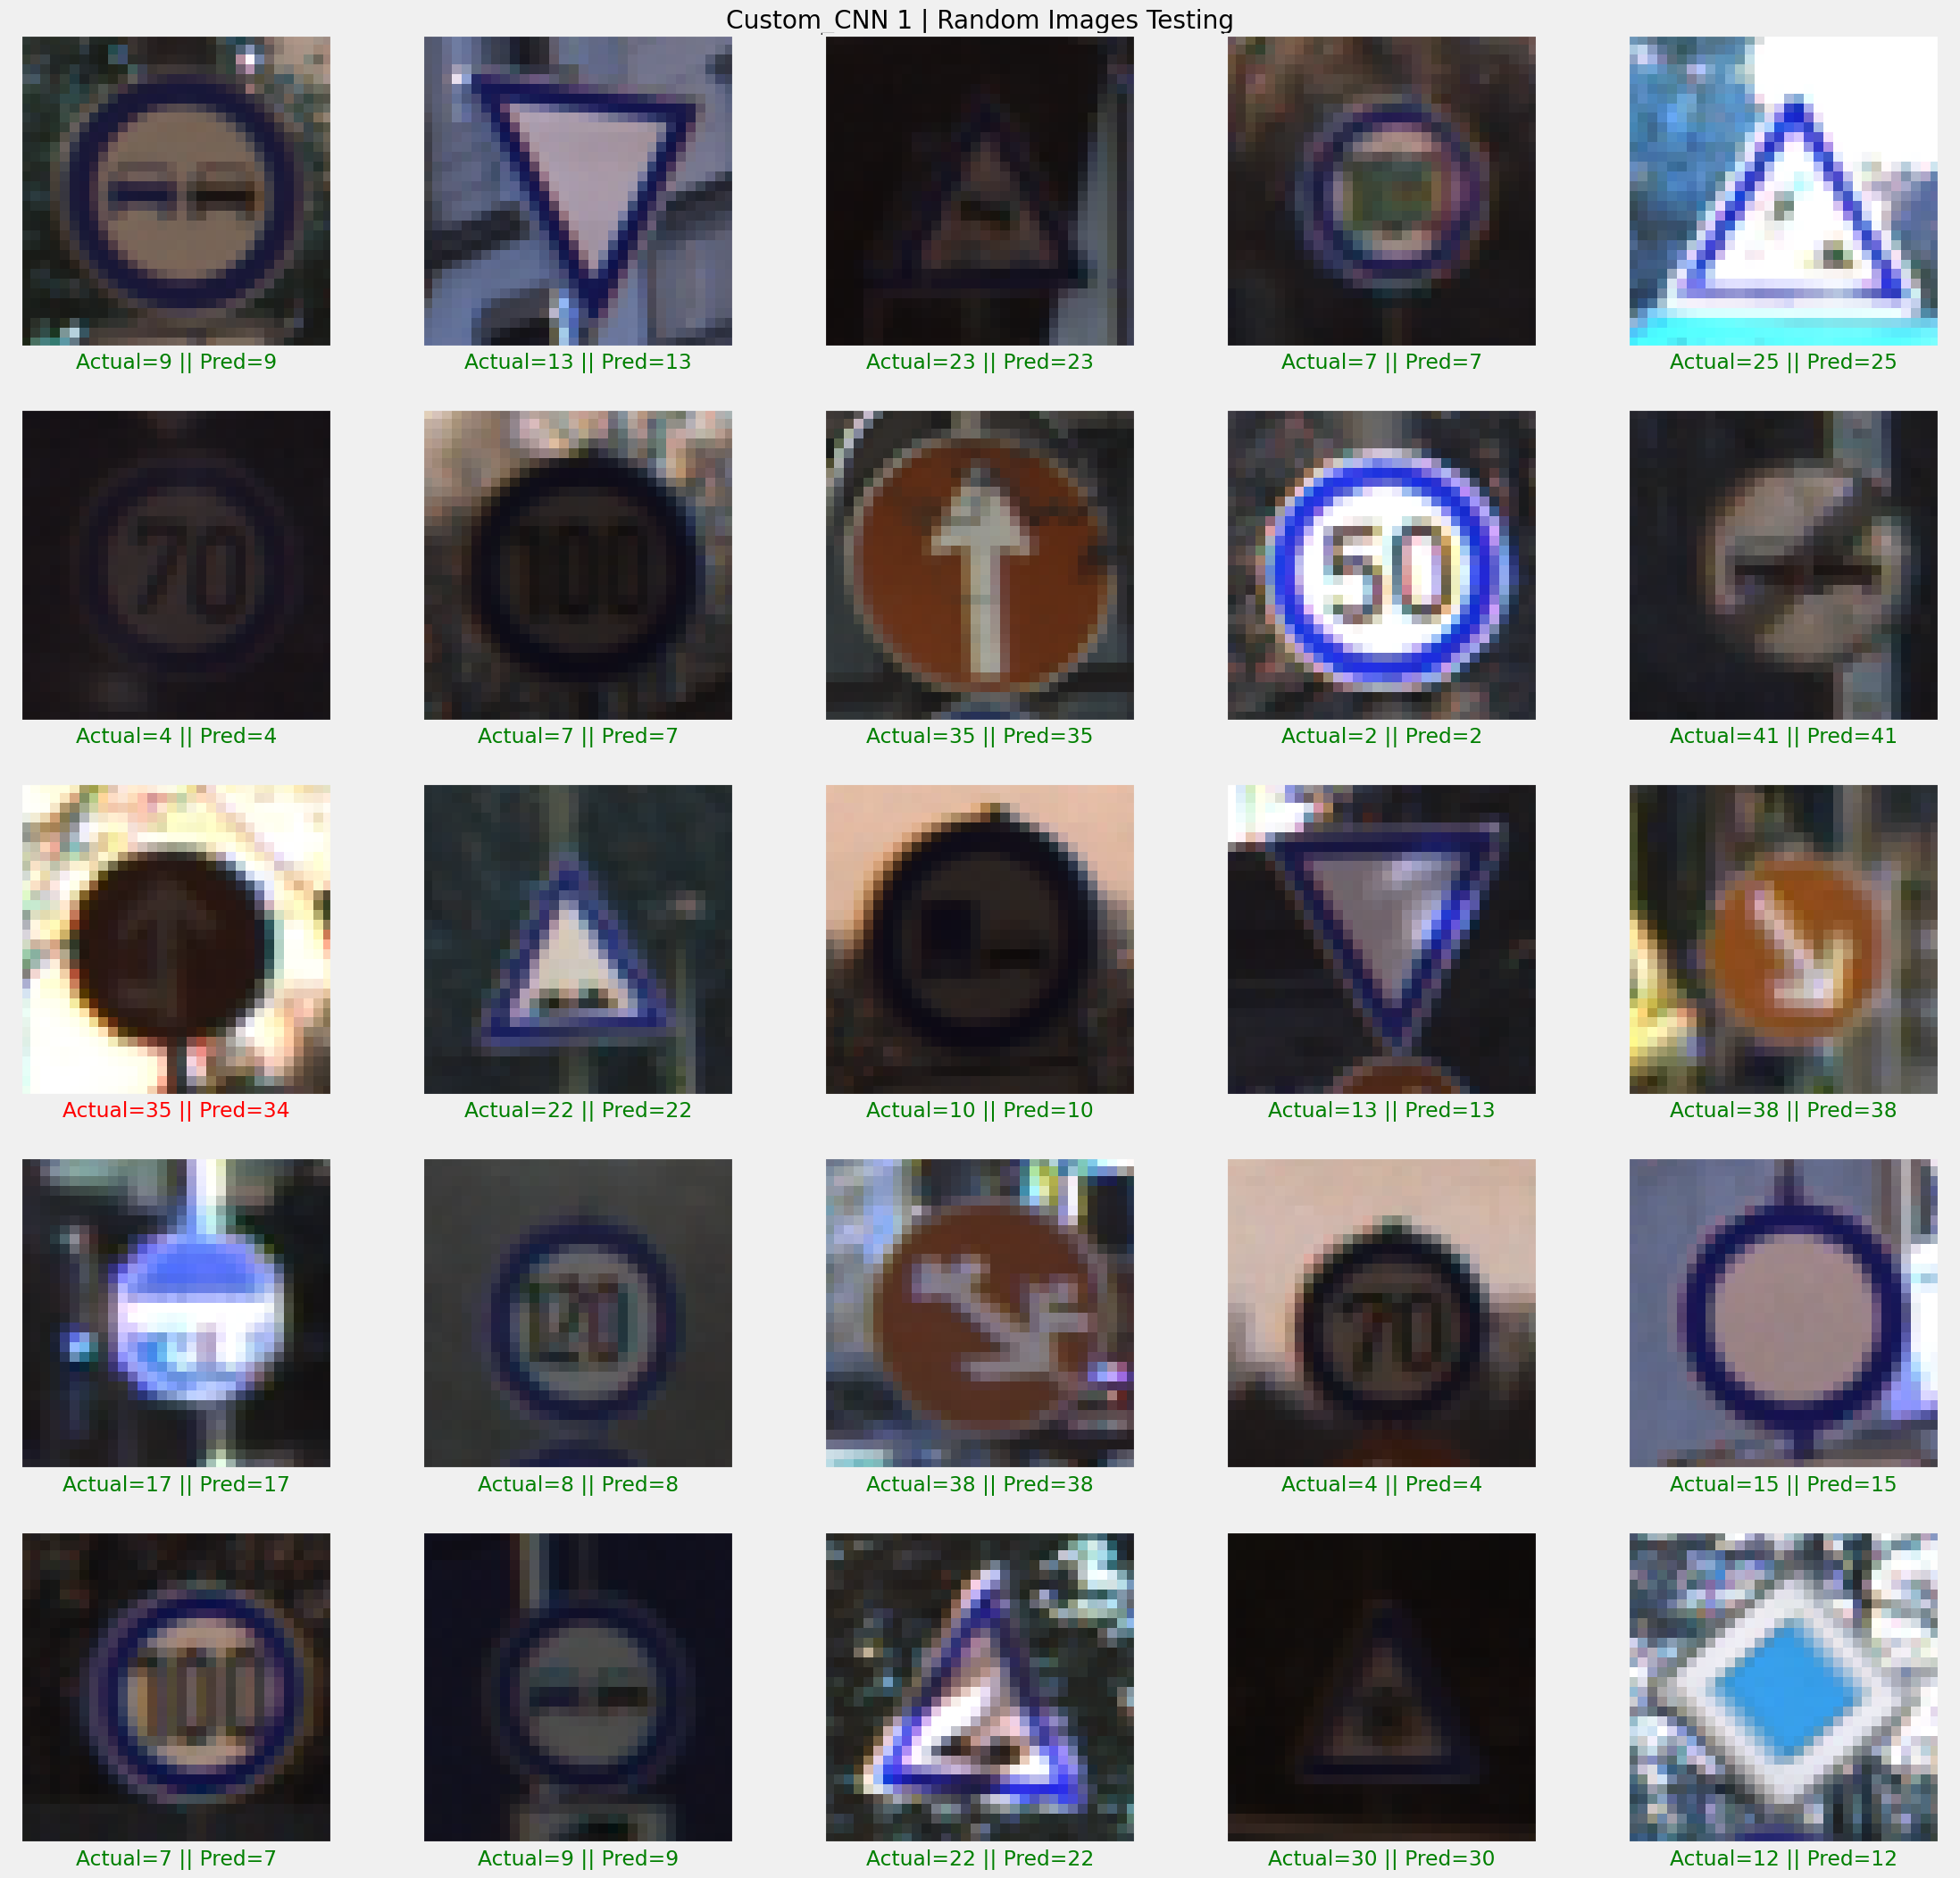

395/395 [==============================] - 0s 1ms/step


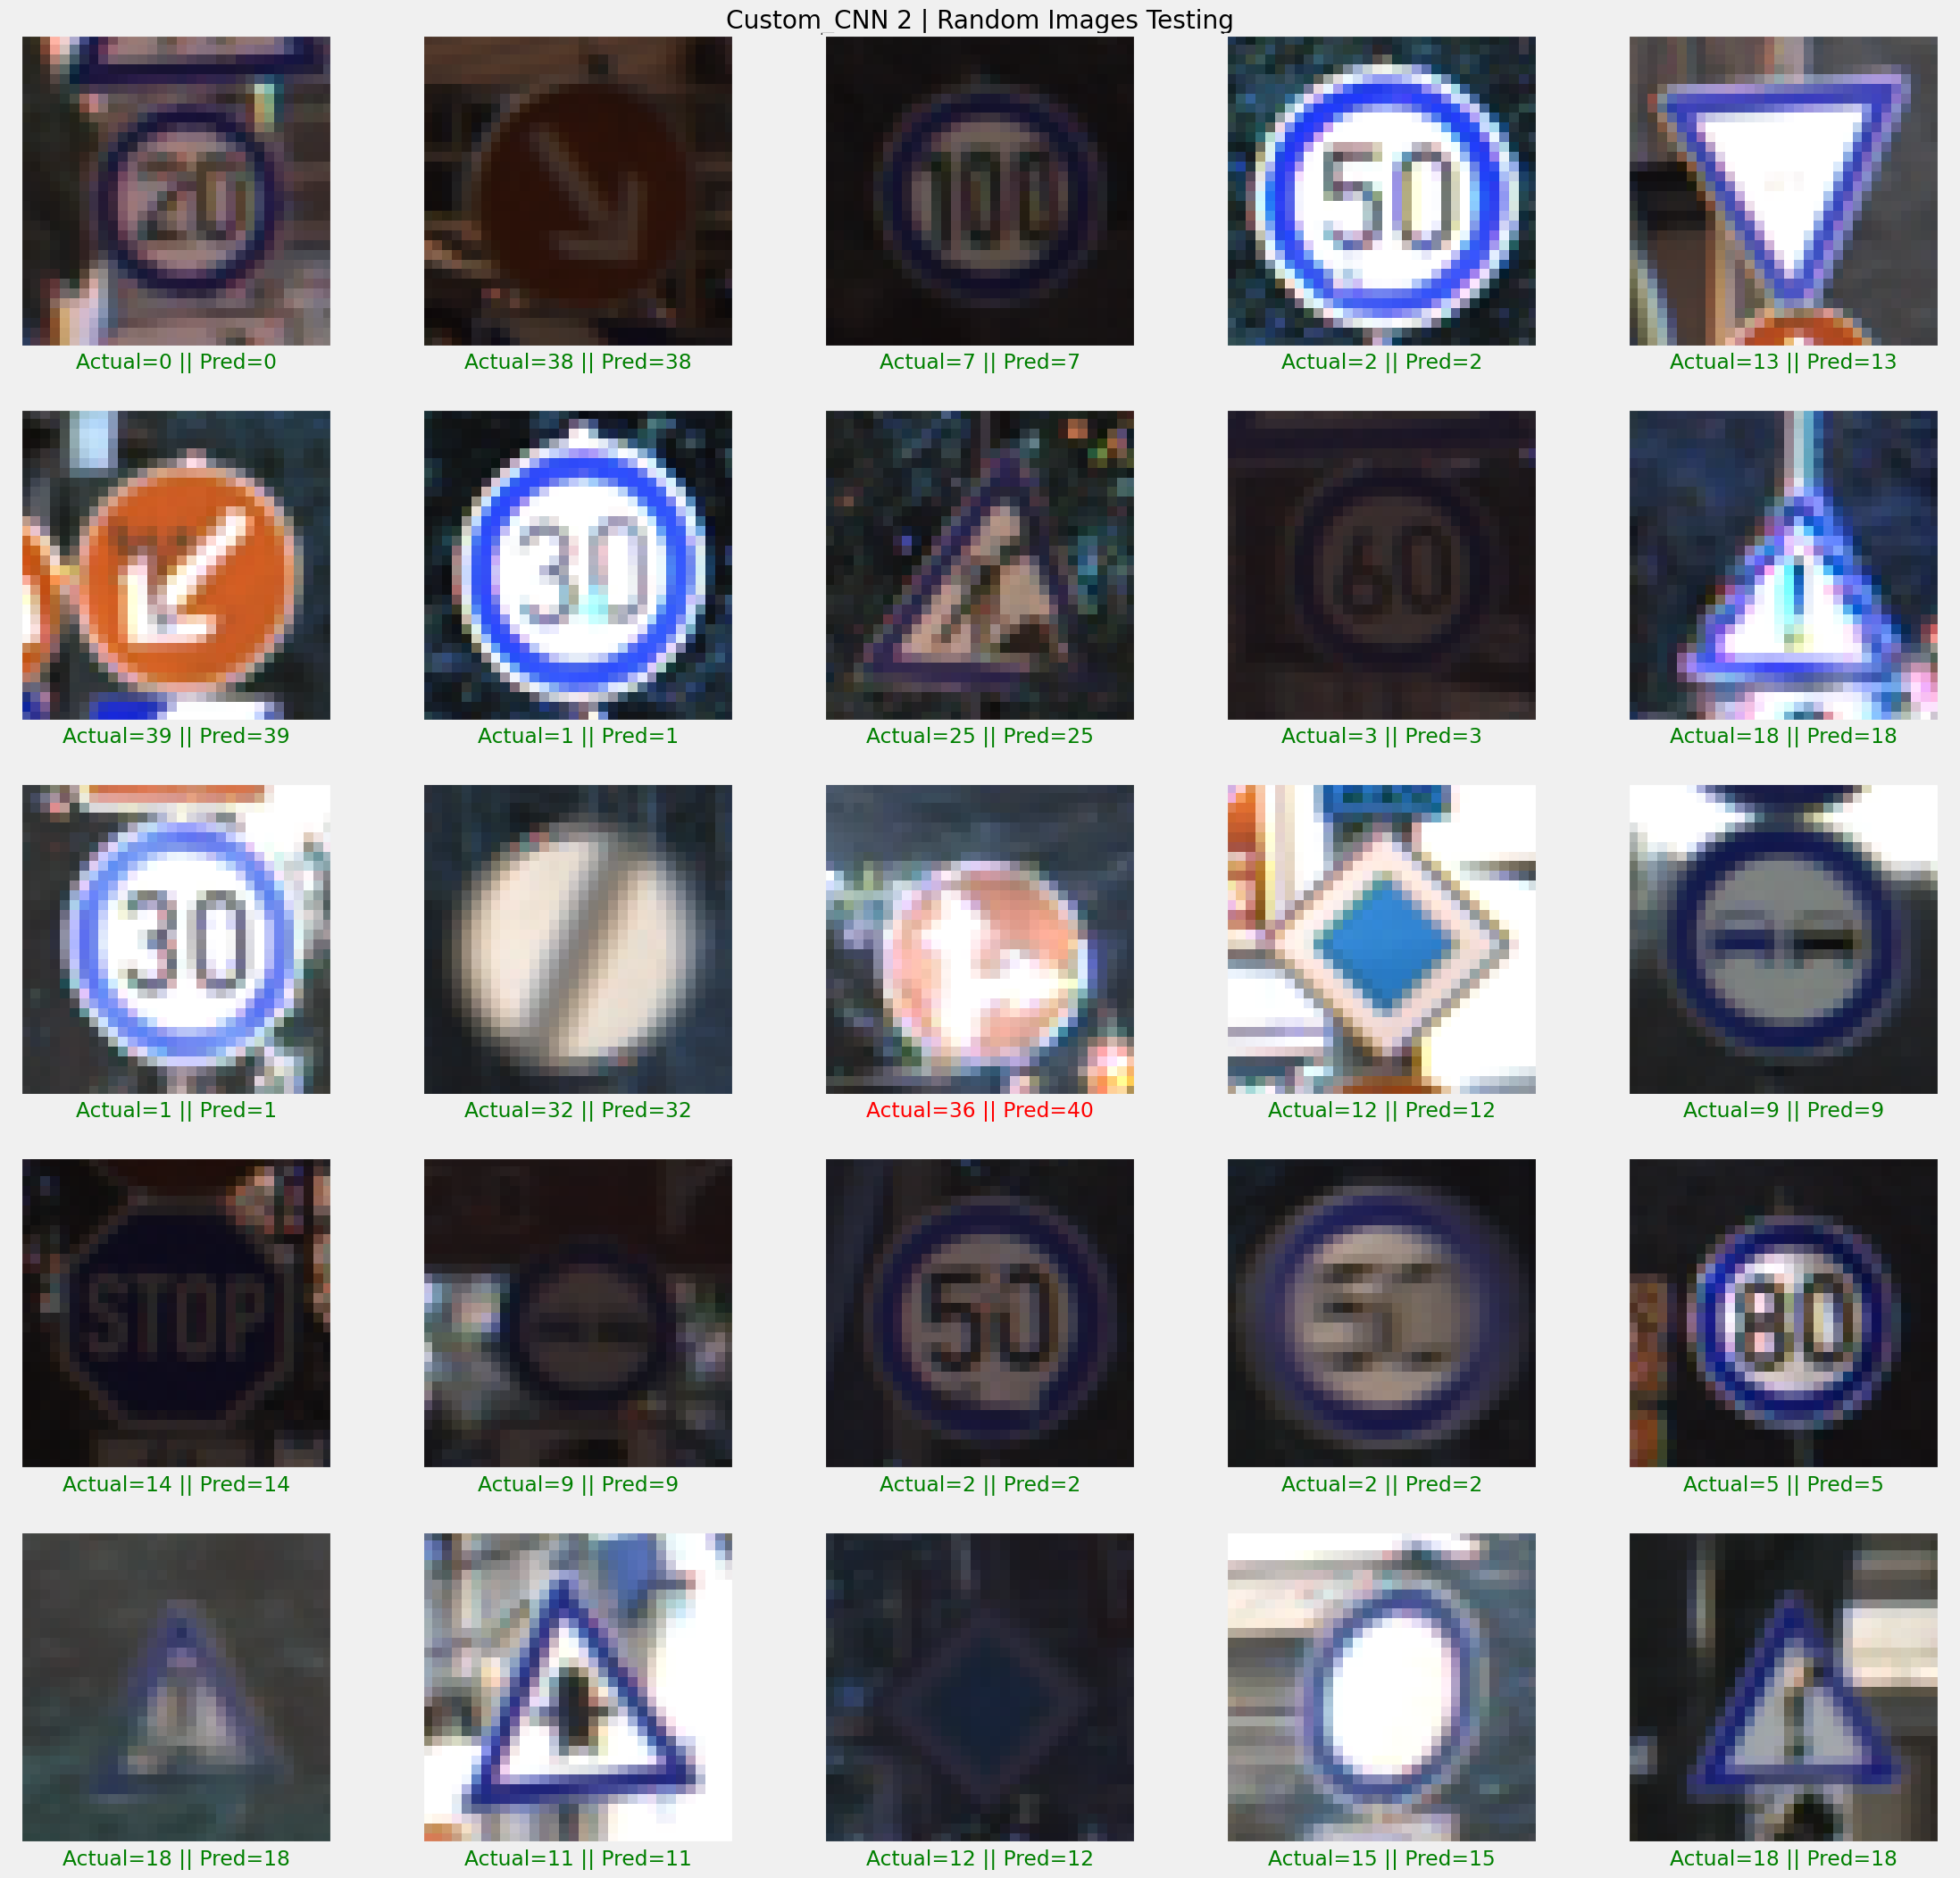

395/395 [==============================] - 2s 6ms/step


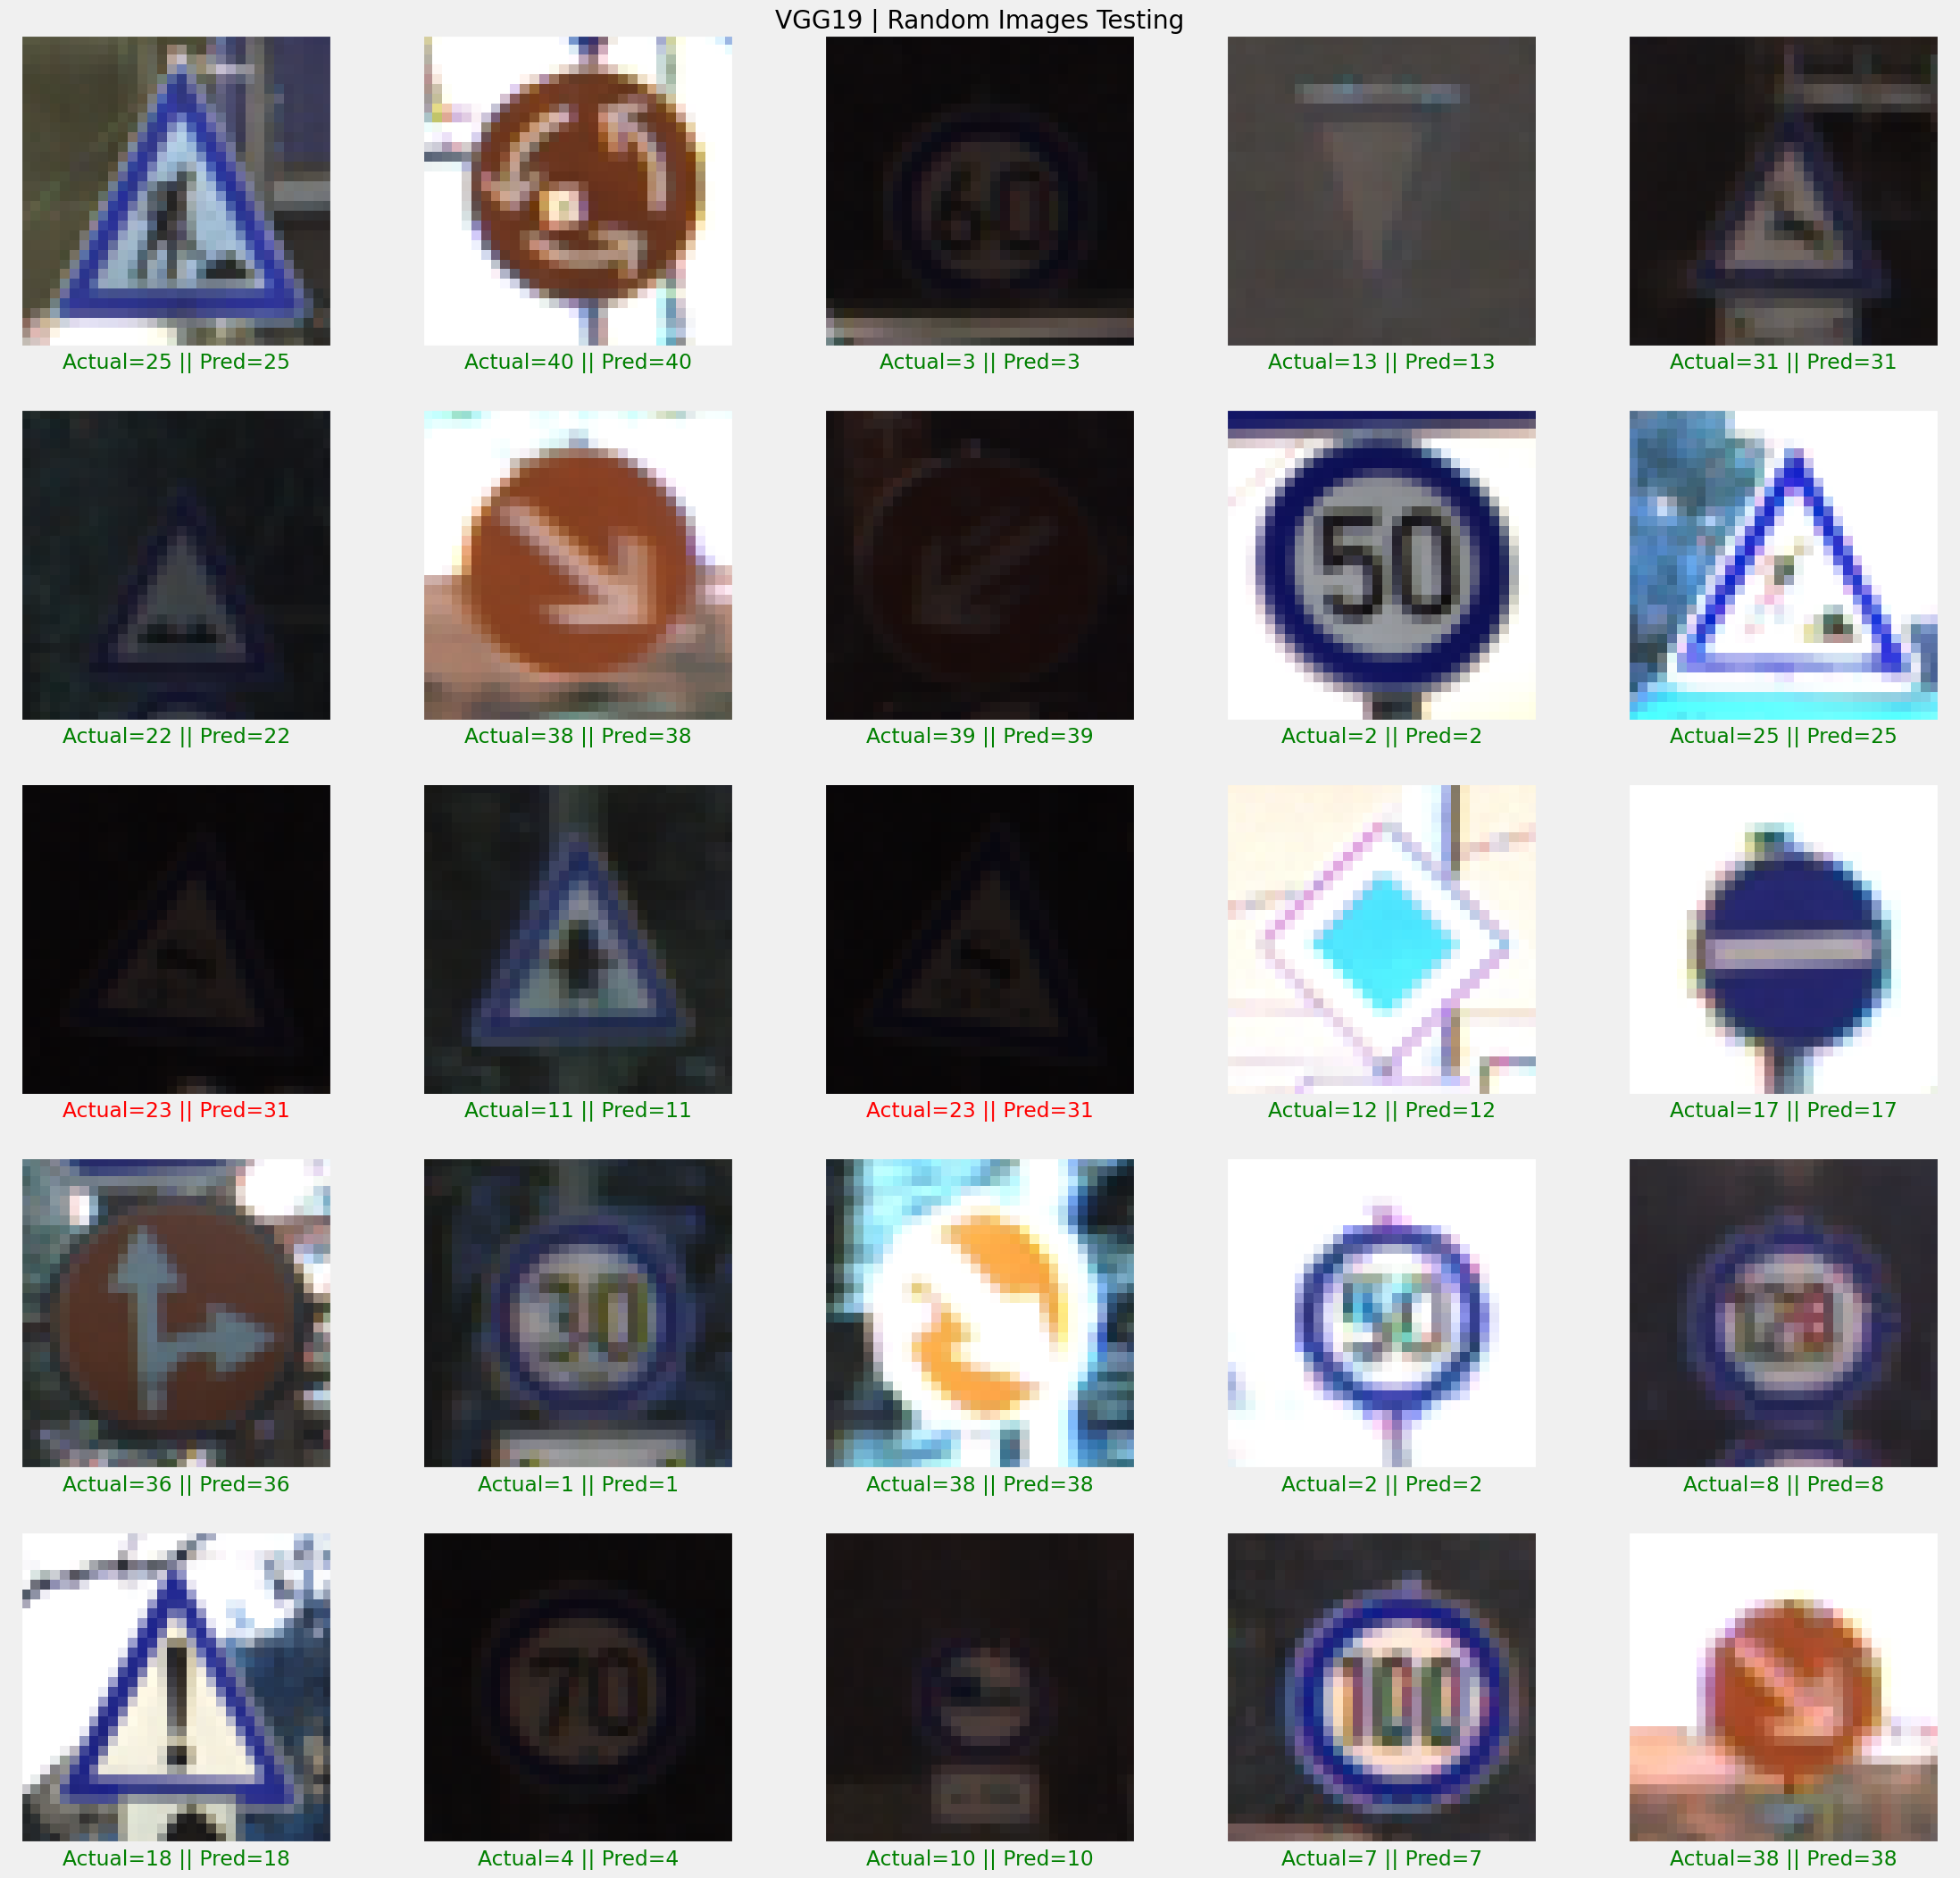

395/395 [==============================] - 3s 8ms/step


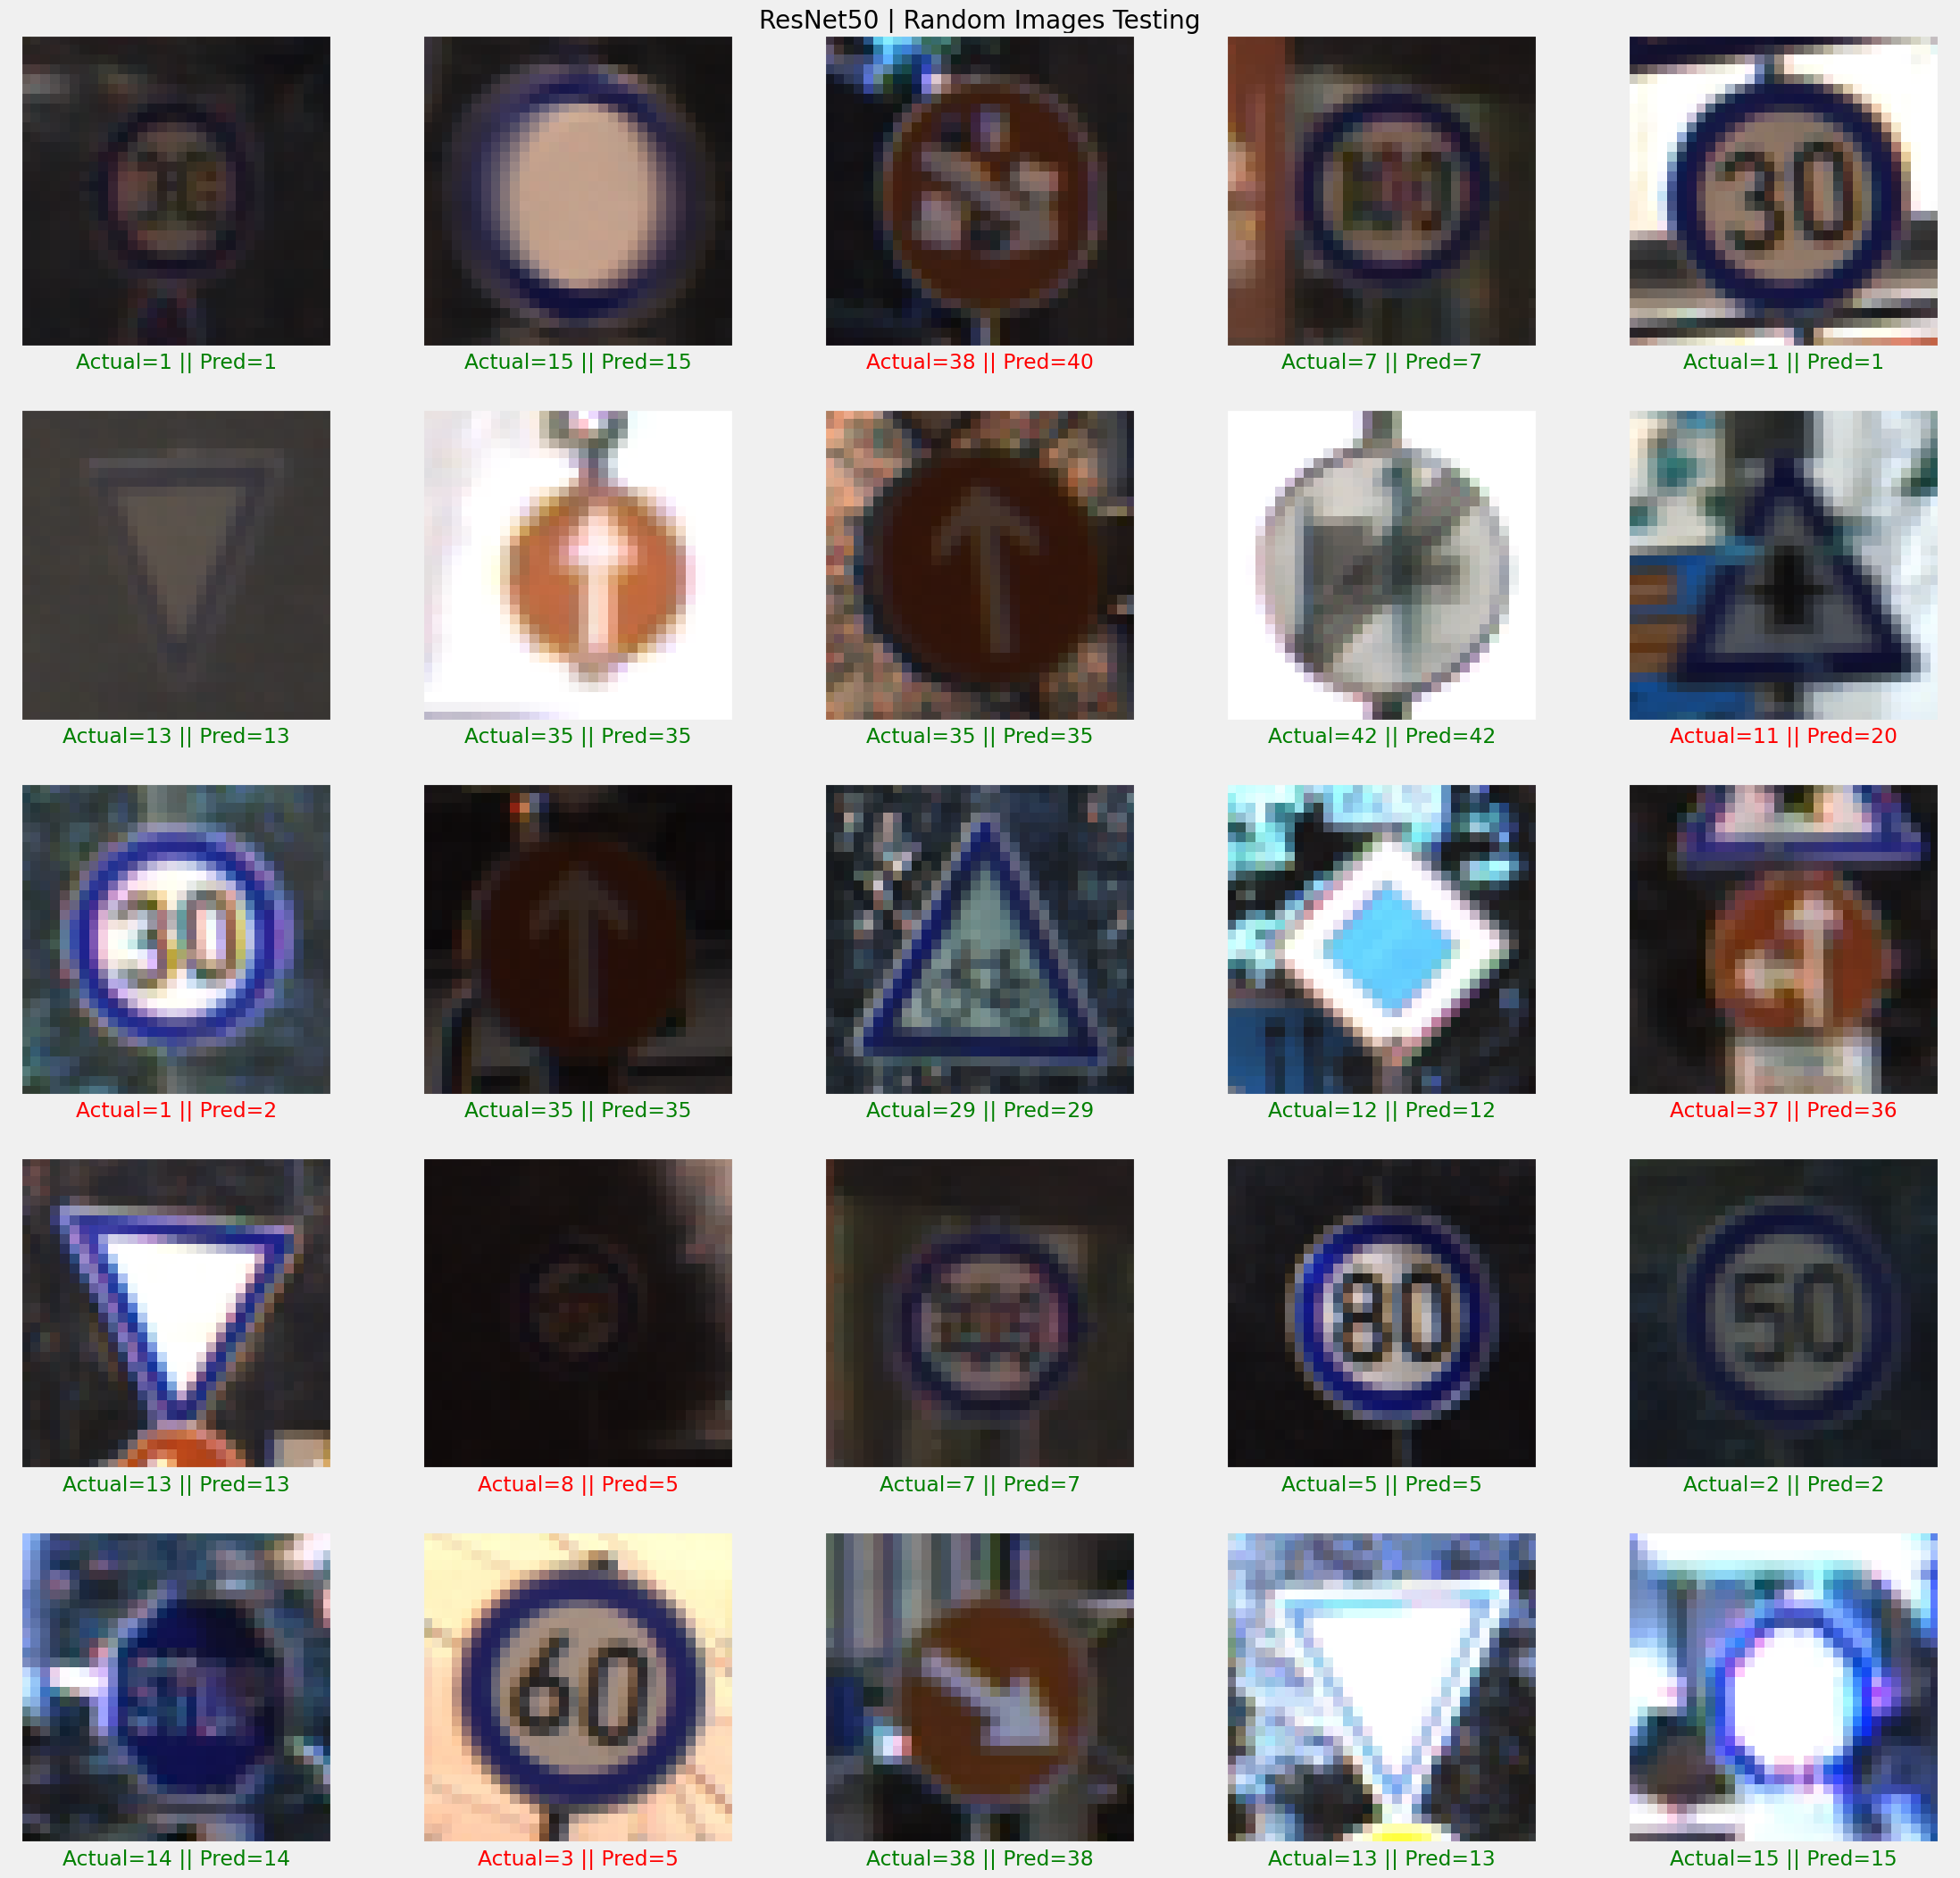

In [43]:
for n, model in enumerate(models):
    pred = np.argmax(model.predict(X_test), axis=-1)

    plt.figure(figsize = (25, 25))
    plt.title(f"{model_labels[n]} | Random Images Testing")
    plt.axis(False)

    start_index = random.randint(0, len(X_test) - 26)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = pred[start_index + i]
        actual = y_test[start_index + i]
        col = 'g'
        if prediction != actual:
            col = 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
        plt.imshow(X_test[start_index + i])
    plt.show()

## Saving the models

In [44]:
model.save('custom_cnn_1.h5')

In [45]:
model2.save('custom_cnn_2.h5')

In [46]:
VGG19_model.save('vgg19.h5')

In [47]:
resnet_model.save("resnet.h5")